## San-Franscisco Crime Predition Challenge - Kaggle
### Team : MIDS-Challengers
### Team Member : Shanti Greene, Jing Xu, Abhishek Kumar
### LeaderBoard Rank : 1 ( As on 17-08-2015)


#### Data Description

This dataset contains incidents derived from SFPD Crime Incident Reporting system. The data ranges from 1/1/2003 to 5/13/2015. The training set and test set rotate every week, meaning week 1,3,5,7... belong to test set, week 2,4,6,8 belong to training set. 

##### train.csv / test.csv

Data fields 

 - Dates - timestamp of the crime incident 
 - Category - category of the crime incident (only in train.csv). This is the target variable you are going to predict. 
 - Descript - detailed description of the crime incident (only in train.csv) 
 - DayOfWeek - the day of the week 
 - PdDistrict - name of the Police Department District 
 - Resolution - how the crime incident was resolved (only in train.csv) 
 - Address - the approximate street address of the crime incident  
 - X - Longitude 
 - Y - Latitude
 
##### Submission data ( sampleSubmission.csv)

You must submit a csv file with the incident id, all candidate class names, and a probability for each class. The order of the rows does not matter. The file must have a header and should look like the following:


##### evaluation criteria

Submissions are evaluated using the multi-class logarithmic loss. Each incident has been labeled with one true class. For each incident, you must submit a set of predicted probabilities (one for every class). The formula is then,

logloss=−1/N∑i=1 to N ∑ j=1 to M yijlog(pij),

where N is the number of images in the test set, M is the number of class labels, log is the natural logarithm, yij is 1 if observation i is in class j and 0 otherwise, and pij is the predicted probability that observation i belongs to class j.

The submitted probabilities for a given incident are not required to sum to one because they are rescaled prior to being scored (each row is divided by the row sum). In order to avoid the extremes of the log function, predicted probabilities are replaced with max(min(p,1−10−15),10−15).




### Import Required Packages

In [55]:
# import required packages
import pandas as pd
import numpy as np
import os
import math
import gc
import gzip
import re

# Force matplotlib to not use any Xwindows backend.
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from scipy.optimize import minimize
from sklearn.preprocessing import LabelEncoder
from sklearn.cross_validation import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import log_loss, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA, IncrementalPCA, RandomizedPCA


from sklearn.ensemble import GradientBoostingClassifier as GBC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier


## 1 . Data Import

In [2]:
# read train and test data files
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

## 2. Data Cleaning

### 2.1 Cleaning Training Data

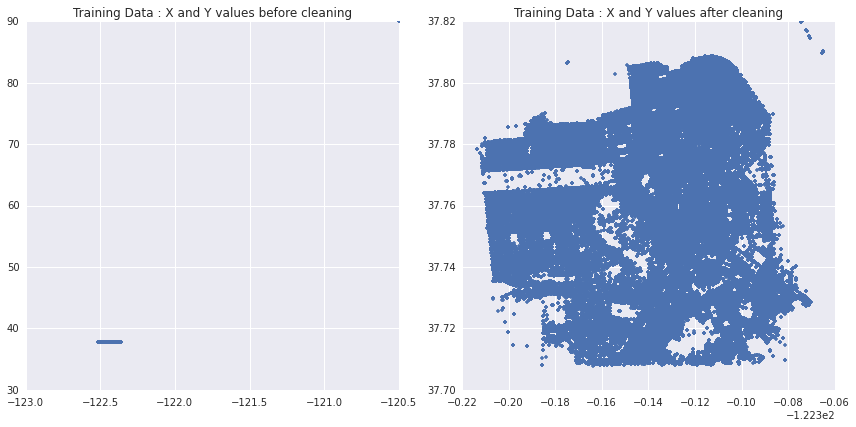

In [3]:
#Some X and Y values seems outlier. We plotted X and Y using a scatter plot, 
#and then removed outlier points
plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
plt.plot(train_df["X"],train_df["Y"],'.')
plt.title('Training Data : X and Y values before cleaning')
train_df=train_df[abs(train_df["Y"])<80] # removing all point for which absolute value of Y is less than 80
plt.subplot(1,2,2)
plt.plot(train_df["X"],train_df["Y"],'.')
plt.title('Training Data : X and Y values after cleaning')
plt.tight_layout()

### 2.2 Cleaning Test Data

mean x : -122.422693192 mean y : 37.7714757446


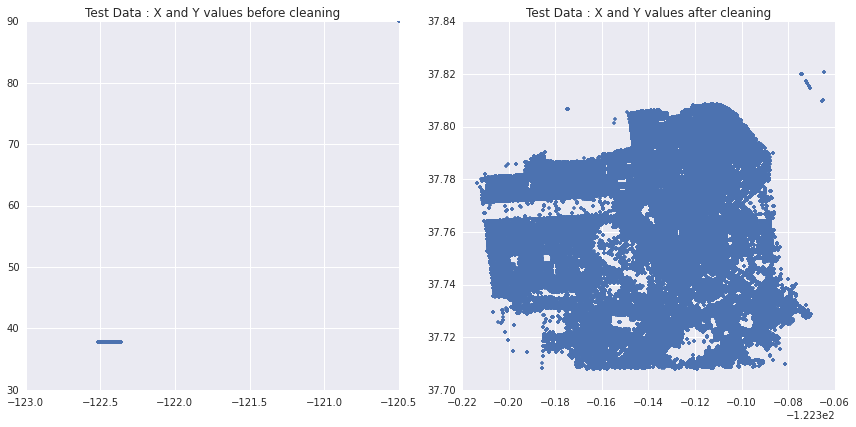

In [4]:
# Some X and Y values in the test data are also outliers. As we cannot remove these rows, therefore we have
# replaced their X and Y values with mean X and mean Y value
plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
plt.plot(test_df["X"],test_df["Y"],'.')
plt.title('Test Data : X and Y values before cleaning')

# mean X and Y value on test
mean_test_df_X = np.mean(test_df["X"].values)
mean_test_df_Y = np.mean(test_df["Y"].values)
print 'mean x : {0} mean y : {1}'.format(mean_test_df_X, mean_test_df_Y)
# replace outlier values 
test_df["X"]=test_df["X"].apply(lambda x: mean_test_df_X if abs(x) <122 else x)
test_df["Y"]=test_df["Y"].apply(lambda y: mean_test_df_Y if abs(y) > 40  else y)
plt.subplot(1,2,2)
plt.plot(test_df["X"],test_df["Y"],'.')
plt.title('Test Data : X and Y values after cleaning')
plt.tight_layout()

## 3. Data Exploration

In [5]:
# show head of train_df
train_df.head(5)

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 877982 entries, 0 to 878048
Data columns (total 9 columns):
Dates         877982 non-null object
Category      877982 non-null object
Descript      877982 non-null object
DayOfWeek     877982 non-null object
PdDistrict    877982 non-null object
Resolution    877982 non-null object
Address       877982 non-null object
X             877982 non-null float64
Y             877982 non-null float64
dtypes: float64(2), object(7)
memory usage: 67.0+ MB


In [7]:
# show head of test_df
test_df.head(5)

,Id,Dates,DayOfWeek,PdDistrict,Address,X,Y
0,0,2015-05-10 23:59:00,Sunday,BAYVIEW,2000 Block of THOMAS AV,-122.399588,37.735051
1,1,2015-05-10 23:51:00,Sunday,BAYVIEW,3RD ST / REVERE AV,-122.391523,37.732432
2,2,2015-05-10 23:50:00,Sunday,NORTHERN,2000 Block of GOUGH ST,-122.426002,37.792212
3,3,2015-05-10 23:45:00,Sunday,INGLESIDE,4700 Block of MISSION ST,-122.437394,37.721412
4,4,2015-05-10 23:45:00,Sunday,INGLESIDE,4700 Block of MISSION ST,-122.437394,37.721412


In [8]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 884262 entries, 0 to 884261
Data columns (total 7 columns):
Id            884262 non-null int64
Dates         884262 non-null object
DayOfWeek     884262 non-null object
PdDistrict    884262 non-null object
Address       884262 non-null object
X             884262 non-null float64
Y             884262 non-null float64
dtypes: float64(2), int64(1), object(4)
memory usage: 54.0+ MB


In [9]:
train_df['Dates'] = train_df['Dates'].astype('datetime64[ns]')   

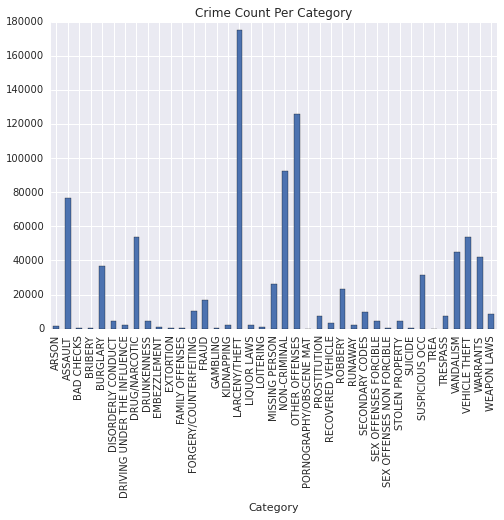

In [38]:
train_df.groupby(['Category'])['PdDistrict'].count().plot(kind='bar')
plt.title('Crime Count Per Category')

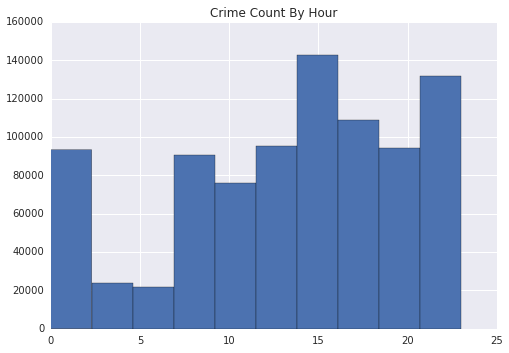

In [10]:
plt.hist(train_df['Dates'].map(lambda d: d.hour))
plt.title('Crime Count By Hour')

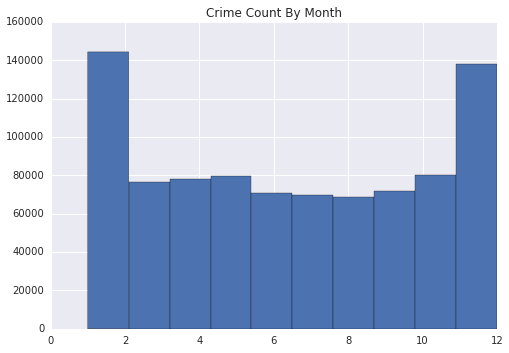

In [11]:
plt.hist(train_df['Dates'].map(lambda d: d.month))
plt.title('Crime Count By Month')

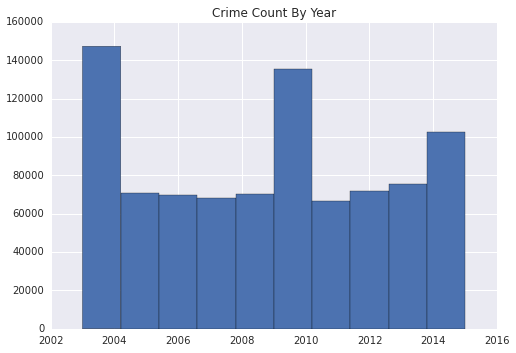

In [12]:
plt.hist(train_df['Dates'].map(lambda d: d.year))
plt.title('Crime Count By Year')

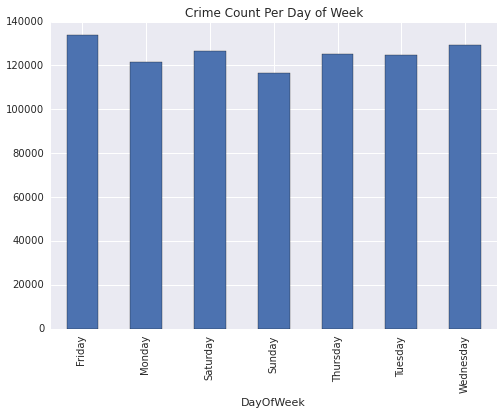

In [13]:
train_df.groupby(['DayOfWeek'])['Category'].count().plot(kind='bar')
plt.title('Crime Count Per Day of Week')

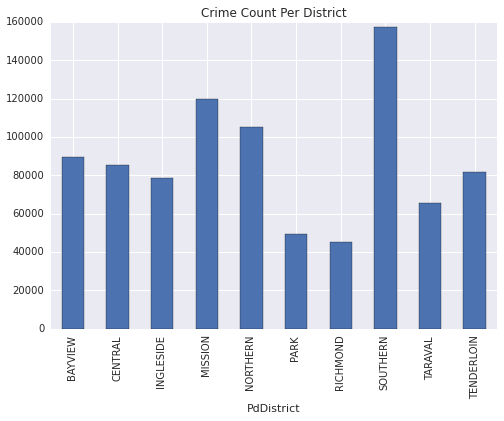

In [14]:
train_df.groupby(['PdDistrict'])['Category'].count().plot(kind='bar')
plt.title('Crime Count Per District')

In [ ]:
#Crime density plots

# Supplied map bounding box:
#    ll.lon     ll.lat   ur.lon     ur.lat
#    -122.52469 37.69862 -122.33663 37.82986
mapdata = np.loadtxt("sf_map_copyright_openstreetmap_contributors.txt")
asp = mapdata.shape[0] * 1.0 / mapdata.shape[1]
lon_lat_box = (-122.5247, -122.3366, 37.699, 37.8299)
clipsize = [[-122.5247, -122.3366],[ 37.699, 37.8299]]

#Seaborn FacetGrid, split by crime Category
g=sns.FacetGrid(train_df, col="Category", col_wrap=6, size=5, aspect=1/asp)

#add the background map
for ax in g.axes:
    ax.imshow(mapdata, cmap=plt.get_cmap('gray'), extent=lon_lat_box, aspect=asp)
#add the density plot
g.map(sns.kdeplot, "X", "Y", clip=clipsize, cmap="Reds", shade=False)
#plt.savefig('sf_crime_density2.png')

## 4. Feature Engineering

### Feature Names and Encoders for Categories

In [15]:
# creating global variable for different features created using label encoding/ manually

unique_categories = train_df['Category'].unique()
print unique_categories

# for discrict
Unique_PdDistricts = train_df['PdDistrict'].unique()
PdDistrict_features = ['PdDistrict_{0}'.format(district) for district in Unique_PdDistricts]

# for days of week
Unique_DayOfWeek = train_df['DayOfWeek'].unique()
DayOfWeek_features = ['DayOfWeek_{0}'.format(day) for day in Unique_DayOfWeek]
# for month
month_features = ['Month_{0}'.format(month) for month in range(1,13)]

# for year
year_features = ['year_{0}'.format(year) for year in range(2003,2016)]

# for season 
season_features = ['season_winter','season_spring','season_summer', 'season_fall']



# for category
category_encoder = LabelEncoder()
category_encoder.fit(unique_categories) 
print category_encoder.classes_

['WARRANTS' 'OTHER OFFENSES' 'LARCENY/THEFT' 'VEHICLE THEFT' 'VANDALISM'
 'NON-CRIMINAL' 'ROBBERY' 'ASSAULT' 'WEAPON LAWS' 'BURGLARY'
 'SUSPICIOUS OCC' 'DRUNKENNESS' 'FORGERY/COUNTERFEITING' 'DRUG/NARCOTIC'
 'STOLEN PROPERTY' 'SECONDARY CODES' 'TRESPASS' 'MISSING PERSON' 'FRAUD'
 'KIDNAPPING' 'RUNAWAY' 'DRIVING UNDER THE INFLUENCE'
 'SEX OFFENSES FORCIBLE' 'PROSTITUTION' 'DISORDERLY CONDUCT' 'ARSON'
 'FAMILY OFFENSES' 'LIQUOR LAWS' 'BRIBERY' 'EMBEZZLEMENT' 'SUICIDE'
 'LOITERING' 'SEX OFFENSES NON FORCIBLE' 'EXTORTION' 'GAMBLING'
 'BAD CHECKS' 'TREA' 'RECOVERED VEHICLE' 'PORNOGRAPHY/OBSCENE MAT']
['ARSON' 'ASSAULT' 'BAD CHECKS' 'BRIBERY' 'BURGLARY' 'DISORDERLY CONDUCT'
 'DRIVING UNDER THE INFLUENCE' 'DRUG/NARCOTIC' 'DRUNKENNESS' 'EMBEZZLEMENT'
 'EXTORTION' 'FAMILY OFFENSES' 'FORGERY/COUNTERFEITING' 'FRAUD' 'GAMBLING'
 'KIDNAPPING' 'LARCENY/THEFT' 'LIQUOR LAWS' 'LOITERING' 'MISSING PERSON'
 'NON-CRIMINAL' 'OTHER OFFENSES' 'PORNOGRAPHY/OBSCENE MAT' 'PROSTITUTION'
 'RECOVERED VEHICLE' 'ROB

### 4.1 Log Odds Per District

In [16]:
def get_log_odds_per_district():
    '''
    Get log odds per district
    '''
    crime_counts_per_district = train_df.groupby(["PdDistrict"]).size()
    log_odds_per_pdDisrict = []
    total_crimes = len(train_df)
    for district in train_df['PdDistrict'].unique():
        current_district_crime_row = []
        current_district_crime_row.append(district)
        current_district_count = crime_counts_per_district[district]
        propertion_crime_current_district =  current_district_count / (float(total_crimes))
        log_odd_current_district = np.log(propertion_crime_current_district) - np.log(1.0 - propertion_crime_current_district)
        current_district_crime_row.append(log_odd_current_district)
        log_odds_per_pdDisrict.append(current_district_crime_row)
    columns = ['PdDistrict' ,'LogOdds_District']
    df_logOddsPerDistrict =  pd.DataFrame(log_odds_per_pdDisrict, columns=columns)
    return df_logOddsPerDistrict


LogOddsPerDistrict = get_log_odds_per_district()
LogOddsPerDistrict

,PdDistrict,LogOdds_District
0,NORTHERN,-1.993227
1,PARK,-2.821676
2,INGLESIDE,-2.316104
3,BAYVIEW,-2.176842
4,RICHMOND,-2.913628
5,CENTRAL,-2.227237
6,TARAVAL,-2.516527
7,TENDERLOIN,-2.275631
8,MISSION,-1.844066
9,SOUTHERN,-1.523019


### 4.2 Log Odds Per District (For Test Data : Including Train and Test Data)

In [17]:
def update_log_odds_per_district_test():
    '''
    Update Log Odds given test data
    '''
    # find districts common in both train and test data
    train_districts = sorted(train_df["PdDistrict"].unique())
    test_districts = sorted(test_df["PdDistrict"].unique())
    common_districts = set(train_districts).intersection(test_districts)
    only_test_districts = set(train_districts + test_districts) - set(train_districts)
    print 'only test: {0}'.format(only_test_districts)
    log_odds_per_pdDisrict = []
    total_crimes_train = len(train_df)
    total_crimes_test = len(test_df)
    crime_counts_per_district_train = train_df.groupby(["PdDistrict"]).size()
    crime_counts_per_district_test = test_df.groupby(["PdDistrict"]).size()
    # For only test districts : find log odds
    for district in only_test_districts:
        current_district_crime_row = []
        current_district_crime_row.append(district)
        current_district_count = crime_counts_per_district_test[district]
        propertion_crime_current_district =  current_district_count / (float(total_crimes_train + total_crimes_test))
        log_odd_current_district = np.log(propertion_crime_current_district) - np.log(1.0 - propertion_crime_current_district)
        current_district_crime_row.append(log_odd_current_district)
        log_odds_per_pdDisrict.append(current_district_crime_row)
        
    # for common test and train districts : update log odds   
    for district in common_districts:
        current_district_crime_row = []
        current_district_crime_row.append(district)
        current_district_count = crime_counts_per_district_train[district] + crime_counts_per_district_test[district]
        propertion_crime_current_district =  current_district_count / (float(total_crimes_train + total_crimes_test))
        log_odd_current_district = np.log(propertion_crime_current_district) - np.log(1.0 - propertion_crime_current_district)
        current_district_crime_row.append(log_odd_current_district)
        log_odds_per_pdDisrict.append(current_district_crime_row)
    columns = ['PdDistrict' ,'LogOdds_District']
    df_logOddsPerDistrict_test =  pd.DataFrame(log_odds_per_pdDisrict, columns=columns)
    return df_logOddsPerDistrict_test


LogOddsPerDistrictTest = update_log_odds_per_district_test()
LogOddsPerDistrictTest

only test: set([])


,PdDistrict,LogOdds_District
0,CENTRAL,-2.226825
1,NORTHERN,-1.987968
2,INGLESIDE,-2.311399
3,PARK,-2.815960
4,MISSION,-1.845586
5,TENDERLOIN,-2.279884
6,RICHMOND,-2.920077
7,TARAVAL,-2.511973
8,BAYVIEW,-2.179765
9,SOUTHERN,-1.526275


### 4.3 Log Odds Per District Per Category

In [18]:
def get_log_odds_per_district_per_category():
    '''
    Get log odds per district per category
    '''
    crime_counts_per_district = train_df.groupby(["PdDistrict"]).size()
    crime_counts_per_district_category = train_df.groupby(["PdDistrict","Category"]).size()
    crime_counts_per_category = train_df.groupby(["Category"]).size() 
    log_odds_per_pdDisrict_category = []
    total_crimes = len(train_df)
    for district in train_df['PdDistrict'].unique():
        current_district_crime_row = []
        current_district_crime_row.append(district)
        current_district_count = crime_counts_per_district[district]      
        for category in train_df['Category'].unique():
            #default log odd 
            default_proportion = crime_counts_per_category[category] / float(total_crimes) 
            default_log_odd = np.log(default_proportion)- np.log(1.0 - default_proportion)
            #check if current category exists for current district
            if category in crime_counts_per_district_category[district].keys():                
                crime_current_district_current_category = crime_counts_per_district_category[district][category]
                if crime_current_district_current_category > 2 and crime_current_district_current_category < current_district_count: # to avoid divide by zero                
                    propertion_crime_current_district_current_category =  crime_current_district_current_category / (float(current_district_count))
                    log_odd_current_district = np.log(propertion_crime_current_district_current_category) - np.log(1.0 - propertion_crime_current_district_current_category)
                    current_district_crime_row.append(log_odd_current_district)
                else:
                    current_district_crime_row.append(default_log_odd) # default value
            else:
                current_district_crime_row.append(default_log_odd) # default value
        log_odds_per_pdDisrict_category.append(current_district_crime_row)
    columns = ['PdDistrict'] + list('logodds_dist_' + unique_categories)
    df_logOddsPerDistrict =  pd.DataFrame(log_odds_per_pdDisrict_category, columns=columns)
    return df_logOddsPerDistrict


LogOddsPerDistrictPerCategory = get_log_odds_per_district_per_category()
LogOddsPerDistrictPerCategory

,PdDistrict,logodds_dist_WARRANTS,logodds_dist_OTHER OFFENSES,logodds_dist_LARCENY/THEFT,logodds_dist_VEHICLE THEFT,logodds_dist_VANDALISM,logodds_dist_NON-CRIMINAL,logodds_dist_ROBBERY,logodds_dist_ASSAULT,logodds_dist_WEAPON LAWS,...,logodds_dist_EMBEZZLEMENT,logodds_dist_SUICIDE,logodds_dist_LOITERING,logodds_dist_SEX OFFENSES NON FORCIBLE,logodds_dist_EXTORTION,logodds_dist_GAMBLING,logodds_dist_BAD CHECKS,logodds_dist_TREA,logodds_dist_RECOVERED VEHICLE,logodds_dist_PORNOGRAPHY/OBSCENE MAT
0,NORTHERN,-3.087068,-2.029288,-0.984943,-2.755929,-2.916830,-2.228038,-3.660488,-2.455939,-4.886128,...,-6.687974,-7.359088,-6.299892,-9.367107,-8.386135,-9.261737,-7.574920,-11.893615,-5.952349,-9.954931
1,PARK,-3.009294,-1.942184,-1.479679,-2.437914,-2.883202,-1.990956,-3.922501,-2.567157,-4.920901,...,-6.892865,-7.809765,-7.669942,-9.014021,-8.726299,-8.701608,-8.097548,-11.893615,-6.041353,-10.594314
2,INGLESIDE,-3.407415,-1.603893,-1.902567,-2.054024,-2.615264,-2.351813,-3.306106,-2.109076,-4.230779,...,-6.917490,-7.099976,-8.016762,-8.183867,-7.907525,-8.502397,-7.809047,-11.893615,-4.771491,-10.594314
3,BAYVIEW,-2.980109,-1.445597,-2.058973,-2.432475,-2.753583,-2.614600,-3.464123,-2.088620,-3.975821,...,-6.794833,-7.789790,-7.488540,-8.309834,-8.836027,-8.033502,-7.874381,-10.302476,-4.792998,-10.594314
4,RICHMOND,-3.778593,-1.949809,-1.272569,-2.301588,-2.581312,-1.927081,-4.033104,-2.573894,-4.921676,...,-6.956745,-6.980297,-8.639278,-8.416090,-7.582893,-9.332514,-7.284223,-11.893615,-5.887814,-10.594314
5,CENTRAL,-3.393582,-2.152084,-0.879746,-2.960007,-2.897112,-1.918575,-3.731672,-2.420199,-5.161766,...,-6.160680,-7.260698,-7.106430,-9.409753,-7.423323,-7.921395,-7.180597,-11.893615,-6.171877,-10.594314
6,TARAVAL,-3.678554,-1.889544,-1.512485,-2.269985,-2.523434,-2.137708,-3.821763,-2.398494,-4.742168,...,-6.546480,-7.012772,-7.564330,-8.382930,-7.507141,-9.011646,-7.507141,-11.893615,-5.518862,-9.704854
7,TENDERLOIN,-2.319240,-1.601653,-1.982543,-4.387861,-3.904295,-2.298571,-3.587548,-2.267272,-4.625121,...,-6.799986,-8.015792,-6.006194,-9.702460,-9.232420,-8.826906,-8.367288,-11.893615,-6.405033,-10.594314
8,MISSION,-2.840629,-1.649327,-1.719185,-2.758420,-3.074987,-2.162381,-3.467027,-2.277775,-4.491144,...,-6.873155,-7.417205,-6.440604,-8.138832,-8.436158,-8.803950,-7.865447,-11.893615,-5.907932,-10.595834
9,SOUTHERN,-2.789321,-1.852641,-1.013947,-3.474181,-3.135322,-1.940207,-3.677051,-2.476630,-4.929705,...,-6.346586,-7.887196,-5.900919,-9.131787,-8.327281,-9.131787,-7.660573,-11.893615,-6.176135,-10.578789


### 4.4 Update Log Odds Per District Per Category (including training and test data)

In [58]:
# Not needed as no new district in the test data

### 4.5 Log Odds Per Address

In [19]:
def get_log_odds_per_address():
    '''
    Get log odds per address
    '''
    crime_counts_per_address = train_df.groupby(["Address"]).size()
    log_odds_per_address = []
    total_crimes = len(train_df)
    for address in train_df['Address'].unique():
        current_address_crime_row = []
        current_address_crime_row.append(address)
        current_address_count = crime_counts_per_address[address]
        propertion_crime_current_address =  current_address_count / (float(total_crimes))
        log_odd_current_address = np.log(propertion_crime_current_address) - np.log(1.0 - propertion_crime_current_address)
        current_address_crime_row.append(log_odd_current_address)
        log_odds_per_address.append(current_address_crime_row)
    columns = ['Address' ,'LogOdds_Address']
    df_logOddsPerAddress =  pd.DataFrame(log_odds_per_address, columns=columns)
    return df_logOddsPerAddress


LogOddsPerAddress = get_log_odds_per_address()
LogOddsPerAddress.head(10)

,Address,LogOdds_Address
0,OAK ST / LAGUNA ST,-9.878668
1,VANNESS AV / GREENWICH ST,-10.549861
2,1500 Block of LOMBARD ST,-8.641780
3,100 Block of BRODERICK ST,-9.734078
4,0 Block of TEDDY AV,-9.465796
5,AVALON AV / PERU AV,-13.685380
6,KIRKWOOD AV / DONAHUE ST,-12.299082
7,600 Block of 47TH AV,-10.640835
8,JEFFERSON ST / LEAVENWORTH ST,-10.284150
9,0 Block of ESCOLTA WY,-11.488147


### 4.6 Update Log Odds Per Address

In [20]:
def update_log_odds_per_address_test():
    '''
    Update Log Odds given test data
    '''
    # find address common in both train and test data
    train_address = sorted(train_df["Address"].unique())
    test_address = sorted(test_df["Address"].unique())
    common_address = set(train_address).intersection(test_address)
    only_test_address = set(train_address + test_address) - set(train_address)
    print 'train : {0} test : {1} only test: {2}'.format(len(train_address), len(test_address), len(only_test_address))
    log_odds_per_address = []
    total_crimes_train = len(train_df)
    total_crimes_test = len(test_df)
    crime_counts_per_address_train = train_df.groupby(["Address"]).size()
    crime_counts_per_address_test = test_df.groupby(["Address"]).size()
   
    # For only test districts : find log odds
    for address in only_test_address:
        current_address_crime_row = []
        current_address_crime_row.append(address)
        current_address_count = crime_counts_per_address_test[address]
        propertion_crime_current_address =  current_address_count / (float(total_crimes_train + total_crimes_test))
        log_odd_current_address = np.log(propertion_crime_current_address) - np.log(1.0 - propertion_crime_current_address)
        current_address_crime_row.append(log_odd_current_address)
        log_odds_per_address.append(current_address_crime_row)
        
    # for common test and train districts : update log odds   
    for address in common_address:
        current_address_crime_row = []
        current_address_crime_row.append(address)
        current_address_count = crime_counts_per_address_train[address] + crime_counts_per_address_test[address]
        propertion_crime_current_address =  current_address_count / (float(total_crimes_train + total_crimes_test))
        log_odd_current_address = np.log(propertion_crime_current_address) - np.log(1.0 - propertion_crime_current_address)
        current_address_crime_row.append(log_odd_current_address)
        log_odds_per_address.append(current_address_crime_row)
    
   
        
    columns = ['Address' ,'LogOdds_Address']
    df_logOddsPeraddress_test =  pd.DataFrame(log_odds_per_address, columns=columns)
    return df_logOddsPeraddress_test


LogOddsPerAddressTest = update_log_odds_per_address_test()
print LogOddsPerAddressTest.shape
LogOddsPerAddressTest.head(10)

train : 23191 test : 23184 only test: 1563
(23184, 2)


,Address,LogOdds_Address
0,BELLAIR PL / PFEIFFER ST,-14.382098
1,LABICA WY / ROCKDALE DR,-14.382098
2,2200 Block of GREAT HWY,-14.382098
3,DOLORES ST / HIDALGO TR,-13.688950
4,SWEENY ST / COLBY ST,-14.382098
5,300 Block of HUNTERSPOINT BL,-14.382098
6,SKYLINE BLVD HY / HARDING RD,-13.688950
7,LEGIONOFHONOR DR / ELCAMINODELMAR ST,-14.382098
8,TEDDY AV / ALPHA ST,-13.283485
9,DOUGLASS ST / JERSEY ST,-14.382098


### 4.7 Log Odds Per Address Per Category

In [12]:
def get_log_odds_per_address_per_category():
    '''
    Log Odds per address per category
    Note: This will take substantial amount of time, You can also read the output file (at next step)
    '''
    crime_counts_per_address = train_df.groupby(["Address"]).size()
    crime_counts_per_address_category = train_df.groupby(["Address","Category"]).size()
    crime_counts_per_category = train_df.groupby(["Category"]).size()  
    log_odds_per_address_category = []
    total_crimes = len(train_df)
    for address in train_df['Address'].unique():
        current_address_crime_row = []
        current_address_crime_row.append(address)
        current_address_count = crime_counts_per_address[address]       
        for category in train_df['Category'].unique():
            #default log odd 
            default_proportion = crime_counts_per_category[category] / float(total_crimes) 
            default_log_odd = np.log(default_proportion) - np.log(1.0 - default_proportion)
            #check if current category exists for current district
            if category in crime_counts_per_address_category[address].keys():                
                crime_current_address_current_category = crime_counts_per_address_category[address][category]
                if crime_current_address_current_category > 2 and crime_current_address_current_category < current_address_count: # to avoid divide by zero                
                    propertion_crime_current_address_current_category =  crime_current_address_current_category / (float(current_address_count))
                    log_odd_current_address = np.log(propertion_crime_current_address_current_category) - np.log(1.0 - propertion_crime_current_address_current_category)
                    current_address_crime_row.append(log_odd_current_address)
                else:
                    current_address_crime_row.append(default_log_odd) #default value
            else:
                current_address_crime_row.append(default_log_odd) # default value
        log_odds_per_address_category.append(current_address_crime_row)
    columns = ['Address'] + list('logodds_address_' + unique_categories)
    df_logOddsPerAddressPerCategory =  pd.DataFrame(log_odds_per_address_category, columns=columns)
    return df_logOddsPerAddressPerCategory


LogOddsPerAddressPerCategory = get_log_odds_per_address_per_category()
# Save to disk for next work
LogOddsPerAddressPerCategory.to_csv('LogOddsPerAddressPerCategory.csv', index=False,header=True)
LogOddsPerAddressPerCategory.head(10)


,Address,logodds_address_WARRANTS,logodds_address_OTHER OFFENSES,logodds_address_LARCENY/THEFT,logodds_address_VEHICLE THEFT,logodds_address_VANDALISM,logodds_address_NON-CRIMINAL,logodds_address_ROBBERY,logodds_address_ASSAULT,logodds_address_WEAPON LAWS,...,logodds_address_EMBEZZLEMENT,logodds_address_SUICIDE,logodds_address_LOITERING,logodds_address_SEX OFFENSES NON FORCIBLE,logodds_address_EXTORTION,logodds_address_GAMBLING,logodds_address_BAD CHECKS,logodds_address_TREA,logodds_address_RECOVERED VEHICLE,logodds_address_PORNOGRAPHY/OBSCENE MAT
0,OAK ST / LAGUNA ST,-2.639057,-1.128465,-0.044452,-2.327278,-2.924890,-2.141545,-3.615665,-2.343883,-4.621396,...,-6.622794,-7.454398,-6.573365,-8.688077,-8.139989,-8.701685,-7.678642,-11.893691,-5.630537,-10.59439
1,VANNESS AV / GREENWICH ST,-2.985679,-1.041454,-0.087011,-2.729575,-2.924890,-2.141545,-3.615665,-2.343883,-4.621396,...,-6.622794,-7.454398,-6.573365,-8.688077,-8.139989,-8.701685,-7.678642,-11.893691,-5.630537,-10.59439
2,1500 Block of LOMBARD ST,-3.925268,-2.477938,-0.597837,-3.401197,-3.212187,-2.786382,-3.615665,-2.910991,-4.621396,...,-6.622794,-7.454398,-6.573365,-8.688077,-8.139989,-8.701685,-7.678642,-11.893691,-5.630537,-10.59439
3,100 Block of BRODERICK ST,-2.985679,-2.240710,-1.563976,-2.240710,-2.240710,-2.240710,-3.615665,-2.343883,-4.621396,...,-6.622794,-7.454398,-6.573365,-8.688077,-8.139989,-8.701685,-7.678642,-11.893691,-5.630537,-10.59439
4,0 Block of TEDDY AV,-2.985679,-2.164964,-1.645156,-1.757858,-2.533697,-2.335375,-3.615665,-1.880313,-4.621396,...,-6.622794,-7.454398,-6.573365,-8.688077,-8.139989,-8.701685,-7.678642,-11.893691,-5.630537,-10.59439
5,AVALON AV / PERU AV,-2.985679,-1.784834,-1.391354,-2.729575,-2.924890,-2.141545,-3.615665,-2.343883,-4.621396,...,-6.622794,-7.454398,-6.573365,-8.688077,-8.139989,-8.701685,-7.678642,-11.893691,-5.630537,-10.59439
6,KIRKWOOD AV / DONAHUE ST,-2.985679,-1.784834,-1.391354,-2.729575,-2.924890,-2.141545,-3.615665,-2.343883,-4.621396,...,-6.622794,-7.454398,-6.573365,-8.688077,-8.139989,-8.701685,-7.678642,-11.893691,-5.630537,-10.59439
7,600 Block of 47TH AV,-2.985679,-1.784834,-0.693147,-1.446919,-1.791759,-2.141545,-3.615665,-2.343883,-4.621396,...,-6.622794,-7.454398,-6.573365,-8.688077,-8.139989,-8.701685,-7.678642,-11.893691,-5.630537,-10.59439
8,JEFFERSON ST / LEAVENWORTH ST,-2.197225,-1.871802,-1.011601,-2.729575,-2.924890,-1.386294,-3.615665,-2.343883,-4.621396,...,-6.622794,-7.454398,-6.573365,-8.688077,-8.139989,-8.701685,-7.678642,-11.893691,-5.630537,-10.59439
9,0 Block of ESCOLTA WY,-2.985679,-1.784834,-1.391354,-2.729575,-2.924890,-2.141545,-3.615665,-2.343883,-4.621396,...,-6.622794,-7.454398,-6.573365,-8.688077,-8.139989,-8.701685,-7.678642,-11.893691,-5.630537,-10.59439


In [21]:
# read train and test data files
LogOddsPerAddressPerCategory = pd.read_csv('LogOddsPerAddressPerCategory.csv')
LogOddsPerAddressPerCategory.head(10)

,Address,logodds_address_WARRANTS,logodds_address_OTHER OFFENSES,logodds_address_LARCENY/THEFT,logodds_address_VEHICLE THEFT,logodds_address_VANDALISM,logodds_address_NON-CRIMINAL,logodds_address_ROBBERY,logodds_address_ASSAULT,logodds_address_WEAPON LAWS,...,logodds_address_EMBEZZLEMENT,logodds_address_SUICIDE,logodds_address_LOITERING,logodds_address_SEX OFFENSES NON FORCIBLE,logodds_address_EXTORTION,logodds_address_GAMBLING,logodds_address_BAD CHECKS,logodds_address_TREA,logodds_address_RECOVERED VEHICLE,logodds_address_PORNOGRAPHY/OBSCENE MAT
0,OAK ST / LAGUNA ST,-2.639057,-1.128465,-0.044452,-2.327278,-2.924833,-2.141508,-3.615631,-2.343857,-4.621318,...,-6.622718,-7.454321,-6.573289,-8.688001,-8.139912,-8.701608,-7.678566,-11.893615,-5.63046,-10.594314
1,VANNESS AV / GREENWICH ST,-2.985798,-1.041454,-0.087011,-2.729672,-2.924833,-2.141508,-3.615631,-2.343857,-4.621318,...,-6.622718,-7.454321,-6.573289,-8.688001,-8.139912,-8.701608,-7.678566,-11.893615,-5.63046,-10.594314
2,1500 Block of LOMBARD ST,-3.925268,-2.477938,-0.597837,-3.401197,-3.212187,-2.786382,-3.615631,-2.910991,-4.621318,...,-6.622718,-7.454321,-6.573289,-8.688001,-8.139912,-8.701608,-7.678566,-11.893615,-5.63046,-10.594314
3,100 Block of BRODERICK ST,-2.985798,-2.240710,-1.563976,-2.240710,-2.240710,-2.240710,-3.615631,-2.343857,-4.621318,...,-6.622718,-7.454321,-6.573289,-8.688001,-8.139912,-8.701608,-7.678566,-11.893615,-5.63046,-10.594314
4,0 Block of TEDDY AV,-2.985798,-2.164964,-1.645156,-1.757858,-2.533697,-2.335375,-3.615631,-1.880313,-4.621318,...,-6.622718,-7.454321,-6.573289,-8.688001,-8.139912,-8.701608,-7.678566,-11.893615,-5.63046,-10.594314
5,AVALON AV / PERU AV,-2.985798,-1.784902,-1.391366,-2.729672,-2.924833,-2.141508,-3.615631,-2.343857,-4.621318,...,-6.622718,-7.454321,-6.573289,-8.688001,-8.139912,-8.701608,-7.678566,-11.893615,-5.63046,-10.594314
6,KIRKWOOD AV / DONAHUE ST,-2.985798,-1.784902,-1.391366,-2.729672,-2.924833,-2.141508,-3.615631,-2.343857,-4.621318,...,-6.622718,-7.454321,-6.573289,-8.688001,-8.139912,-8.701608,-7.678566,-11.893615,-5.63046,-10.594314
7,600 Block of 47TH AV,-2.985798,-1.784902,-0.693147,-1.446919,-1.791759,-2.141508,-3.615631,-2.343857,-4.621318,...,-6.622718,-7.454321,-6.573289,-8.688001,-8.139912,-8.701608,-7.678566,-11.893615,-5.63046,-10.594314
8,JEFFERSON ST / LEAVENWORTH ST,-2.197225,-1.871802,-1.011601,-2.729672,-2.924833,-1.386294,-3.615631,-2.343857,-4.621318,...,-6.622718,-7.454321,-6.573289,-8.688001,-8.139912,-8.701608,-7.678566,-11.893615,-5.63046,-10.594314
9,0 Block of ESCOLTA WY,-2.985798,-1.784902,-1.391366,-2.729672,-2.924833,-2.141508,-3.615631,-2.343857,-4.621318,...,-6.622718,-7.454321,-6.573289,-8.688001,-8.139912,-8.701608,-7.678566,-11.893615,-5.63046,-10.594314


### 4.8 Update Log Odds Per Address Per Category for test 

In [24]:
def update_log_odds_per_address_per_category_test(Train_LogOddsPerAddressPerCategory):
    '''
    Update Log Odds given test data, This method will also take some time. So, you can read the output from saved
    file in the next step
    '''
    # find address common in both train and test data
    train_address = sorted(train_df["Address"].unique())
    test_address = sorted(test_df["Address"].unique())
    common_address = set(train_address).intersection(test_address)
    only_test_address = set(train_address + test_address) - set(train_address)
    print 'train : {0} test : {1} only test: {2}'.format(len(train_address), len(test_address), len(only_test_address))
    
    total_crimes_train = len(train_df)
    total_crimes_test = len(test_df)
    crime_counts_per_category = train_df.groupby(["Category"]).size()  
   
    # for new test rows, we will take the per category log odds derived from training data
    log_odds_per_address_only_test = []
    for address in only_test_address:
        current_address_crime_row = []
        current_address_crime_row.append(address)     
        for category in train_df['Category'].unique():   
             #default log odd 
            default_proportion = crime_counts_per_category[category] / float(total_crimes_train) 
            default_log_odd = np.log(default_proportion) - np.log(1 - default_proportion)            
            current_address_crime_row.append(default_log_odd)
        log_odds_per_address_only_test.append(current_address_crime_row)      
    columns = ['Address'] + list('logodds_address_' + unique_categories)
    df_log_odds_per_address_only_test =  pd.DataFrame(log_odds_per_address_only_test, columns=columns)
    
    # for common test and train districts : No need to update log odds as for test data category info is not available
    # use train log odds 
    df_log_odds_per_address_common = Train_LogOddsPerAddressPerCategory[Train_LogOddsPerAddressPerCategory["Address"] .isin(common_address)]
    # stack both data frames (one of only_Test and other for common)
    df_log_odds_per_address_category_test = pd.concat([df_log_odds_per_address_only_test, df_log_odds_per_address_common], axis=0)    
    return df_log_odds_per_address_category_test


LogOddsPerAddressPerCategoryTest = update_log_odds_per_address_per_category_test(LogOddsPerAddressPerCategory)
# Save to disk for next work
LogOddsPerAddressPerCategoryTest.to_csv('LogOddsPerAddressPerCategoryTest.csv', index=False,header=True)
print LogOddsPerAddressPerCategoryTest.info()
LogOddsPerAddressPerCategoryTest.head(10)

train : 23191 test : 23184 only test: 1563
<class 'pandas.core.frame.DataFrame'>
Int64Index: 23184 entries, 0 to 23187
Data columns (total 40 columns):
Address                                        23184 non-null object
logodds_address_WARRANTS                       23184 non-null float64
logodds_address_OTHER OFFENSES                 23184 non-null float64
logodds_address_LARCENY/THEFT                  23184 non-null float64
logodds_address_VEHICLE THEFT                  23184 non-null float64
logodds_address_VANDALISM                      23184 non-null float64
logodds_address_NON-CRIMINAL                   23184 non-null float64
logodds_address_ROBBERY                        23184 non-null float64
logodds_address_ASSAULT                        23184 non-null float64
logodds_address_WEAPON LAWS                    23184 non-null float64
logodds_address_BURGLARY                       23184 non-null float64
logodds_address_SUSPICIOUS OCC                 23184 non-null float64
logodds_a

,Address,logodds_address_WARRANTS,logodds_address_OTHER OFFENSES,logodds_address_LARCENY/THEFT,logodds_address_VEHICLE THEFT,logodds_address_VANDALISM,logodds_address_NON-CRIMINAL,logodds_address_ROBBERY,logodds_address_ASSAULT,logodds_address_WEAPON LAWS,...,logodds_address_EMBEZZLEMENT,logodds_address_SUICIDE,logodds_address_LOITERING,logodds_address_SEX OFFENSES NON FORCIBLE,logodds_address_EXTORTION,logodds_address_GAMBLING,logodds_address_BAD CHECKS,logodds_address_TREA,logodds_address_RECOVERED VEHICLE,logodds_address_PORNOGRAPHY/OBSCENE MAT
0,BELLAIR PL / PFEIFFER ST,-2.985798,-1.784902,-1.391366,-2.729672,-2.924833,-2.141508,-3.615631,-2.343857,-4.621318,...,-6.622718,-7.454321,-6.573289,-8.688001,-8.139912,-8.701608,-7.678566,-11.893615,-5.63046,-10.594314
1,LABICA WY / ROCKDALE DR,-2.985798,-1.784902,-1.391366,-2.729672,-2.924833,-2.141508,-3.615631,-2.343857,-4.621318,...,-6.622718,-7.454321,-6.573289,-8.688001,-8.139912,-8.701608,-7.678566,-11.893615,-5.63046,-10.594314
2,2200 Block of GREAT HWY,-2.985798,-1.784902,-1.391366,-2.729672,-2.924833,-2.141508,-3.615631,-2.343857,-4.621318,...,-6.622718,-7.454321,-6.573289,-8.688001,-8.139912,-8.701608,-7.678566,-11.893615,-5.63046,-10.594314
3,DOLORES ST / HIDALGO TR,-2.985798,-1.784902,-1.391366,-2.729672,-2.924833,-2.141508,-3.615631,-2.343857,-4.621318,...,-6.622718,-7.454321,-6.573289,-8.688001,-8.139912,-8.701608,-7.678566,-11.893615,-5.63046,-10.594314
4,SWEENY ST / COLBY ST,-2.985798,-1.784902,-1.391366,-2.729672,-2.924833,-2.141508,-3.615631,-2.343857,-4.621318,...,-6.622718,-7.454321,-6.573289,-8.688001,-8.139912,-8.701608,-7.678566,-11.893615,-5.63046,-10.594314
5,300 Block of HUNTERSPOINT BL,-2.985798,-1.784902,-1.391366,-2.729672,-2.924833,-2.141508,-3.615631,-2.343857,-4.621318,...,-6.622718,-7.454321,-6.573289,-8.688001,-8.139912,-8.701608,-7.678566,-11.893615,-5.63046,-10.594314
6,SKYLINE BLVD HY / HARDING RD,-2.985798,-1.784902,-1.391366,-2.729672,-2.924833,-2.141508,-3.615631,-2.343857,-4.621318,...,-6.622718,-7.454321,-6.573289,-8.688001,-8.139912,-8.701608,-7.678566,-11.893615,-5.63046,-10.594314
7,LEGIONOFHONOR DR / ELCAMINODELMAR ST,-2.985798,-1.784902,-1.391366,-2.729672,-2.924833,-2.141508,-3.615631,-2.343857,-4.621318,...,-6.622718,-7.454321,-6.573289,-8.688001,-8.139912,-8.701608,-7.678566,-11.893615,-5.63046,-10.594314
8,TEDDY AV / ALPHA ST,-2.985798,-1.784902,-1.391366,-2.729672,-2.924833,-2.141508,-3.615631,-2.343857,-4.621318,...,-6.622718,-7.454321,-6.573289,-8.688001,-8.139912,-8.701608,-7.678566,-11.893615,-5.63046,-10.594314
9,DOUGLASS ST / JERSEY ST,-2.985798,-1.784902,-1.391366,-2.729672,-2.924833,-2.141508,-3.615631,-2.343857,-4.621318,...,-6.622718,-7.454321,-6.573289,-8.688001,-8.139912,-8.701608,-7.678566,-11.893615,-5.63046,-10.594314


In [22]:
# read train and test data files
LogOddsPerAddressPerCategoryTest = pd.read_csv('LogOddsPerAddressPerCategoryTest.csv')
LogOddsPerAddressPerCategoryTest.head(10)

,Address,logodds_address_WARRANTS,logodds_address_OTHER OFFENSES,logodds_address_LARCENY/THEFT,logodds_address_VEHICLE THEFT,logodds_address_VANDALISM,logodds_address_NON-CRIMINAL,logodds_address_ROBBERY,logodds_address_ASSAULT,logodds_address_WEAPON LAWS,...,logodds_address_EMBEZZLEMENT,logodds_address_SUICIDE,logodds_address_LOITERING,logodds_address_SEX OFFENSES NON FORCIBLE,logodds_address_EXTORTION,logodds_address_GAMBLING,logodds_address_BAD CHECKS,logodds_address_TREA,logodds_address_RECOVERED VEHICLE,logodds_address_PORNOGRAPHY/OBSCENE MAT
0,BELLAIR PL / PFEIFFER ST,-2.985798,-1.784902,-1.391366,-2.729672,-2.924833,-2.141508,-3.615631,-2.343857,-4.621318,...,-6.622718,-7.454321,-6.573289,-8.688001,-8.139912,-8.701608,-7.678566,-11.893615,-5.63046,-10.594314
1,LABICA WY / ROCKDALE DR,-2.985798,-1.784902,-1.391366,-2.729672,-2.924833,-2.141508,-3.615631,-2.343857,-4.621318,...,-6.622718,-7.454321,-6.573289,-8.688001,-8.139912,-8.701608,-7.678566,-11.893615,-5.63046,-10.594314
2,2200 Block of GREAT HWY,-2.985798,-1.784902,-1.391366,-2.729672,-2.924833,-2.141508,-3.615631,-2.343857,-4.621318,...,-6.622718,-7.454321,-6.573289,-8.688001,-8.139912,-8.701608,-7.678566,-11.893615,-5.63046,-10.594314
3,DOLORES ST / HIDALGO TR,-2.985798,-1.784902,-1.391366,-2.729672,-2.924833,-2.141508,-3.615631,-2.343857,-4.621318,...,-6.622718,-7.454321,-6.573289,-8.688001,-8.139912,-8.701608,-7.678566,-11.893615,-5.63046,-10.594314
4,SWEENY ST / COLBY ST,-2.985798,-1.784902,-1.391366,-2.729672,-2.924833,-2.141508,-3.615631,-2.343857,-4.621318,...,-6.622718,-7.454321,-6.573289,-8.688001,-8.139912,-8.701608,-7.678566,-11.893615,-5.63046,-10.594314
5,300 Block of HUNTERSPOINT BL,-2.985798,-1.784902,-1.391366,-2.729672,-2.924833,-2.141508,-3.615631,-2.343857,-4.621318,...,-6.622718,-7.454321,-6.573289,-8.688001,-8.139912,-8.701608,-7.678566,-11.893615,-5.63046,-10.594314
6,SKYLINE BLVD HY / HARDING RD,-2.985798,-1.784902,-1.391366,-2.729672,-2.924833,-2.141508,-3.615631,-2.343857,-4.621318,...,-6.622718,-7.454321,-6.573289,-8.688001,-8.139912,-8.701608,-7.678566,-11.893615,-5.63046,-10.594314
7,LEGIONOFHONOR DR / ELCAMINODELMAR ST,-2.985798,-1.784902,-1.391366,-2.729672,-2.924833,-2.141508,-3.615631,-2.343857,-4.621318,...,-6.622718,-7.454321,-6.573289,-8.688001,-8.139912,-8.701608,-7.678566,-11.893615,-5.63046,-10.594314
8,TEDDY AV / ALPHA ST,-2.985798,-1.784902,-1.391366,-2.729672,-2.924833,-2.141508,-3.615631,-2.343857,-4.621318,...,-6.622718,-7.454321,-6.573289,-8.688001,-8.139912,-8.701608,-7.678566,-11.893615,-5.63046,-10.594314
9,DOUGLASS ST / JERSEY ST,-2.985798,-1.784902,-1.391366,-2.729672,-2.924833,-2.141508,-3.615631,-2.343857,-4.621318,...,-6.622718,-7.454321,-6.573289,-8.688001,-8.139912,-8.701608,-7.678566,-11.893615,-5.63046,-10.594314


### 4.9 Extracting Suffix from Address

In [23]:
def get_suffix(address):
    address = address.strip()
    suffixes = {'al':'alley','av':'Avenue', 'bl': 'Boulevard',
                'cr':'circle','ct':'court','dr':'drive','ex':'expressway',
                'hwy':'highway','hy':'highway','i-280':'highway','i-80':'highway',
                'ln':'lane','mar':'mar','palms':'palms','park':'park','pl':'place',
                'pz':'plaza','rw':'row','rd':'road','st':'street','stwy':'stwy','tr':'terrace',
                'ter':'terrace','way':'way','wk':'wk','wy':'way','ferlinghetti':'art','bufano':'art'}
    suffix = address.lower().rsplit(" ",1)[-1]
    # edge case
    if suffix == '/':        
        address = address[:-1] # removing / from the address
        address = address.strip()
        suffix = address.lower().rsplit(" ",1)[-1]     
    return suffixes[suffix]
    


In [24]:
test_df['Suffix'] = test_df['Address'].map(lambda d: get_suffix(d))
print sorted(test_df['Suffix'].unique())
train_df['Suffix'] = train_df['Address'].map(lambda d: get_suffix(d))
print sorted(train_df['Suffix'].unique())

['Avenue', 'Boulevard', 'alley', 'circle', 'court', 'drive', 'expressway', 'highway', 'lane', 'mar', 'palms', 'park', 'place', 'plaza', 'road', 'row', 'street', 'stwy', 'terrace', 'way', 'wk']
['Avenue', 'Boulevard', 'alley', 'art', 'circle', 'court', 'drive', 'expressway', 'highway', 'lane', 'mar', 'palms', 'park', 'place', 'plaza', 'road', 'row', 'street', 'stwy', 'terrace', 'way', 'wk']


In [25]:
train_df.groupby(['Suffix'])["Address"].count()

Suffix
Avenue        164243
Boulevard      19405
alley            361
art                9
circle           431
court           3125
drive          13502
expressway        14
highway         2927
lane            1821
mar               22
palms             86
park               9
place           1363
plaza           2349
road            3939
row                1
street        656266
stwy              16
terrace         1470
way             6618
wk                 5
Name: Address, dtype: int64

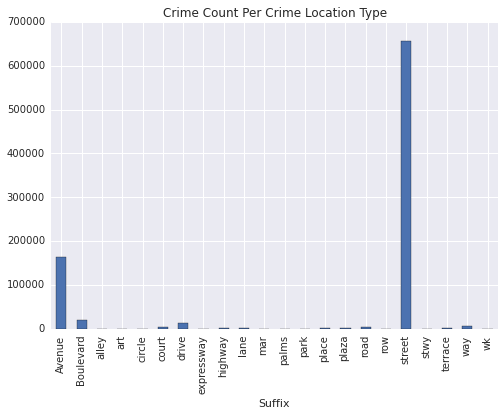

In [26]:
train_df.groupby(['Suffix'])['Address'].count().plot(kind='bar')
plt.title('Crime Count Per Crime Location Type')

In [27]:
test_df.groupby(['Suffix'])["Address"].count()

Suffix
Avenue        166033
Boulevard      19499
alley            373
circle           508
court           3070
drive          13438
expressway        13
highway         2882
lane            1879
mar               15
palms            110
park              12
place           1404
plaza           2413
road            3883
row                7
street        660423
stwy              12
terrace         1602
way             6679
wk                 7
Name: Address, dtype: int64

### 4.10 Lod Odds Per Suffix

In [28]:
def get_log_odds_per_suffix():
    '''
    Get log odds per suffix
    '''
    crime_counts_per_suffix = train_df.groupby(["Suffix"]).size()
    log_odds_per_suffix = []
    total_crimes = len(train_df)
    for suffix in train_df['Suffix'].unique():
        current_suffix_crime_row = []
        current_suffix_crime_row.append(suffix)
        current_suffix_count = crime_counts_per_suffix[suffix]
        propertion_crime_current_suffix =  current_suffix_count / (float(total_crimes))
        log_odd_current_suffix = np.log(propertion_crime_current_suffix) - np.log(1.0 - propertion_crime_current_suffix)
        current_suffix_crime_row.append(log_odd_current_suffix)
        log_odds_per_suffix.append(current_suffix_crime_row)
    columns = ['Suffix' ,'LogOdds_Suffix']
    df_logOddsPerSuffix =  pd.DataFrame(log_odds_per_suffix, columns=columns)
    return df_logOddsPerSuffix


LogOddsPerSuffix = get_log_odds_per_suffix()
LogOddsPerSuffix

,Suffix,LogOdds_Suffix
0,street,1.085169
1,Avenue,-1.469170
2,way,-4.880267
3,Boulevard,-3.789746
4,drive,-4.159290
5,court,-5.634626
6,terrace,-6.390688
7,highway,-5.700309
8,road,-5.402203
9,plaza,-5.920957


### 4.11 Log Odds Per Suffix Per Category

In [29]:
def get_log_odds_per_suffix_per_category():
    '''
    Get log odds per suffix per crime category
    '''
    crime_counts_per_suffix = train_df.groupby(["Suffix"]).size()
    crime_counts_per_suffix_category = train_df.groupby(["Suffix","Category"]).size()
    crime_counts_per_category = train_df.groupby(["Category"]).size() 
    log_odds_per_suffix_category = []
    total_crimes = len(train_df)
    for suffix in train_df['Suffix'].unique():
        current_suffix_crime_row = []
        current_suffix_crime_row.append(suffix)
        current_suffix_count = crime_counts_per_suffix[suffix]      
        for category in train_df['Category'].unique():
            #default log odd 
            default_proportion = crime_counts_per_category[category] / float(total_crimes) 
            default_log_odd = np.log(default_proportion)- np.log(1.0 - default_proportion)
            #check if current category exists for current district
            if category in crime_counts_per_suffix_category[suffix].keys():                
                crime_current_suffix_current_category = crime_counts_per_suffix_category[suffix][category]
                if crime_current_suffix_current_category > 2 and crime_current_suffix_current_category < current_suffix_count: # to avoid divide by zero                
                    propertion_crime_current_suffix_current_category =  crime_current_suffix_current_category / (float(current_suffix_count))
                    log_odd_current_suffix = np.log(propertion_crime_current_suffix_current_category) - np.log(1.0 - propertion_crime_current_suffix_current_category)
                    current_suffix_crime_row.append(log_odd_current_suffix)
                else:
                    current_suffix_crime_row.append(default_log_odd) # default value
            else:
                current_suffix_crime_row.append(default_log_odd) # default value
        log_odds_per_suffix_category.append(current_suffix_crime_row)
    columns = ['Suffix'] + list('logodds_suffix_' + unique_categories)
    df_logOddsPerSuffix =  pd.DataFrame(log_odds_per_suffix_category, columns=columns)
    return df_logOddsPerSuffix


LogOddsPerSuffixPerCategory = get_log_odds_per_suffix_per_category()
LogOddsPerSuffixPerCategory

,Suffix,logodds_suffix_WARRANTS,logodds_suffix_OTHER OFFENSES,logodds_suffix_LARCENY/THEFT,logodds_suffix_VEHICLE THEFT,logodds_suffix_VANDALISM,logodds_suffix_NON-CRIMINAL,logodds_suffix_ROBBERY,logodds_suffix_ASSAULT,logodds_suffix_WEAPON LAWS,...,logodds_suffix_EMBEZZLEMENT,logodds_suffix_SUICIDE,logodds_suffix_LOITERING,logodds_suffix_SEX OFFENSES NON FORCIBLE,logodds_suffix_EXTORTION,logodds_suffix_GAMBLING,logodds_suffix_BAD CHECKS,logodds_suffix_TREA,logodds_suffix_RECOVERED VEHICLE,logodds_suffix_PORNOGRAPHY/OBSCENE MAT
0,street,-2.911919,-1.797237,-1.321566,-2.829538,-3.009110,-2.127952,-3.595578,-2.380839,-4.700874,...,-6.622202,-7.748443,-6.470130,-8.861580,-8.179105,-8.666761,-7.673545,-11.784876,-5.775927,-10.755243
1,Avenue,-3.236141,-1.690051,-1.724866,-2.455025,-2.735093,-2.172726,-3.637430,-2.224396,-4.433056,...,-6.679971,-6.958296,-6.848987,-8.180181,-8.057542,-8.790074,-7.691157,-11.893615,-5.356709,-10.063150
2,way,-3.505262,-1.943495,-1.563367,-2.180216,-2.236104,-2.410822,-3.974921,-2.354192,-4.538420,...,-7.187355,-7.698483,-6.493451,-8.688001,-8.139912,-8.701608,-7.678566,-11.893615,-4.745847,-10.594314
3,Boulevard,-3.429581,-1.880451,-1.130264,-2.532818,-2.724717,-2.149199,-3.536488,-2.349035,-4.834932,...,-6.133450,-7.675598,-7.307667,-8.688001,-8.081217,-8.701608,-7.307667,-11.893615,-5.204369,-10.594314
4,drive,-3.351477,-2.087885,-1.028152,-2.455664,-2.709157,-2.151332,-4.152659,-2.617984,-4.820431,...,-6.417920,-6.944680,-6.573289,-8.124002,-7.564164,-8.701608,-8.124002,-11.893615,-5.481085,-10.594314
5,court,-3.541289,-1.956558,-2.083408,-2.595323,-2.640773,-2.387122,-3.916603,-1.766966,-3.719160,...,-6.253508,-6.659614,-6.573289,-8.688001,-8.139912,-8.701608,-7.678566,-11.893615,-4.820282,-10.594314
6,terrace,-3.743256,-2.102609,-1.369373,-1.982163,-2.332890,-2.307834,-3.805273,-2.718254,-4.056989,...,-6.622718,-6.192362,-6.573289,-8.688001,-8.139912,-8.701608,-7.678566,-11.893615,-4.574711,-10.594314
7,highway,-3.849799,-2.118861,-1.138645,-2.490471,-2.634308,-2.066439,-4.537099,-2.274351,-4.838350,...,-6.622718,-4.570234,-6.573289,-8.688001,-8.139912,-8.701608,-7.678566,-11.893615,-4.714714,-10.594314
8,road,-2.785065,-1.837523,-2.524906,-3.098767,-2.199766,-2.695929,-3.876137,-1.632463,-3.243173,...,-6.622718,-7.179308,-6.891372,-8.688001,-8.139912,-8.701608,-7.678566,-11.893615,-5.053439,-10.594314
9,plaza,-1.902352,-1.369879,-2.721295,-6.373746,-4.708242,-2.211018,-3.258097,-2.290006,-4.030565,...,-6.622718,-7.454321,-6.373746,-8.688001,-8.139912,-8.701608,-7.678566,-11.893615,-5.630460,-10.594314


### 4.11 Update Log Odds Per Suffix 

In [30]:
def update_log_odds_per_suffix_test():
    '''
    Update Log Odds given test data
    '''
    # find districts common in both train and test data
    train_suffix = sorted(train_df["Suffix"].unique())
    test_suffix = sorted(test_df["Suffix"].unique())
    common_suffix = set(train_suffix).intersection(test_suffix)
    only_test_suffix = set(train_suffix + test_suffix) - set(train_suffix)
    print 'only test: {0}'.format(only_test_suffix)
    log_odds_per_suffix = []
    total_crimes_train = len(train_df)
    total_crimes_test = len(test_df)
    crime_counts_per_suffix_train = train_df.groupby(["Suffix"]).size()
    crime_counts_per_suffix_test = test_df.groupby(["Suffix"]).size()
    # For only test suffix : find log odds
    for suffix in only_test_suffix:
        current_suffix_crime_row = []
        current_suffix_crime_row.append(suffix)
        current_suffix_count = crime_counts_per_suffix_test[suffix]
        propertion_crime_current_suffix =  current_suffix_count / (float(total_crimes_train + total_crimes_test))
        log_odd_current_suffix = np.log(propertion_crime_current_suffix) - np.log(1.0 - propertion_crime_current_suffix)
        current_suffix_crime_row.append(log_odd_current_suffix)
        log_odds_per_suffix.append(current_suffix_crime_row)
        
    # for common test and train suffix : update log odds   
    for suffix in common_suffix:
        current_suffix_crime_row = []
        current_suffix_crime_row.append(suffix)
        current_suffix_count = crime_counts_per_suffix_train[suffix] + crime_counts_per_suffix_test[suffix]
        propertion_crime_current_suffix =  current_suffix_count / (float(total_crimes_train + total_crimes_test))
        log_odd_current_suffix = np.log(propertion_crime_current_suffix) - np.log(1.0 - propertion_crime_current_suffix)
        current_suffix_crime_row.append(log_odd_current_suffix)
        log_odds_per_suffix.append(current_suffix_crime_row)
    columns = ['Suffix' ,'LogOdds_Suffix']
    df_logOddsPerSuffix_test =  pd.DataFrame(log_odds_per_suffix, columns=columns)
    return df_logOddsPerSuffix_test


LogOddsPerSuffixTest = update_log_odds_per_suffix_test()
LogOddsPerSuffixTest

only test: set([])


,Suffix,LogOdds_Suffix
0,street,1.083555
1,lane,-6.163909
2,Boulevard,-3.790922
3,court,-5.647079
4,palms,-9.103873
5,terrace,-6.350270
6,plaza,-5.910970
7,park,-11.337564
8,drive,-4.165326
9,alley,-7.783173


### 4.12 Extract NearBy Zone using X and Y

In [31]:
## rounding up X and Y upto 2 decimal to create a localized zone
train_df['loc'] = train_df['X'].map(lambda x: str(round(x,2))) +   train_df['Y'].map(lambda y: ' {0}'.format(str(round(y,2))))
test_df['loc'] = test_df['X'].map(lambda x: str(round(x,2))) +   test_df['Y'].map(lambda y: ' {0}'.format(str(round(y,2))))
unique_cordinates =train_df['loc'].unique().tolist()
print 'Total Zones : {0}'.format(len(unique_cordinates))
#for cordinates
cordinate_features = ['cord_{0}'.format(cord) for cord in unique_cordinates]

Total Zones : 138


### 4.13 Log Odds Per Zone

In [32]:
def get_log_odds_per_loc():
    '''
    Get log odds per loc
    '''
    crime_counts_per_loc = train_df.groupby(["loc"]).size()
    log_odds_per_loc = []
    total_crimes = len(train_df)
    for loc in train_df['loc'].unique():
        current_loc_crime_row = []
        current_loc_crime_row.append(loc)
        current_loc_count = crime_counts_per_loc[loc]
        propertion_crime_current_loc =  current_loc_count / (float(total_crimes))
        log_odd_current_loc = np.log(propertion_crime_current_loc) - np.log(1.0 - propertion_crime_current_loc)
        current_loc_crime_row.append(log_odd_current_loc)
        log_odds_per_loc.append(current_loc_crime_row)
    columns = ['loc' ,'LogOdds_loc']
    df_logOddsPerloc =  pd.DataFrame(log_odds_per_loc, columns=columns)
    return df_logOddsPerloc

LogOddsPerLoc = get_log_odds_per_loc()
LogOddsPerLoc.head(5)

,loc,LogOdds_loc
0,-122.43 37.77,-4.017006
1,-122.42 37.8,-4.580365
2,-122.43 37.8,-4.850264
3,-122.44 37.77,-4.686134
4,-122.4 37.71,-6.147414


### 4.14 Log Odds Per Zone Per Category

In [33]:
def get_log_odds_per_loc_per_category():
    '''
    Get log odds per loc per crime category
    '''
    crime_counts_per_loc = train_df.groupby(["loc"]).size()
    crime_counts_per_loc_category = train_df.groupby(["loc","Category"]).size()
    crime_counts_per_category = train_df.groupby(["Category"]).size() 
    log_odds_per_loc_category = []
    total_crimes = len(train_df)
    for loc in train_df['loc'].unique():
        current_loc_crime_row = []
        current_loc_crime_row.append(loc)
        current_loc_count = crime_counts_per_loc[loc]      
        for category in train_df['Category'].unique():
            #default log odd 
            default_proportion = crime_counts_per_category[category] / float(total_crimes) 
            default_log_odd = np.log(default_proportion)- np.log(1.0 - default_proportion)
            #check if current category exists for current district
            if category in crime_counts_per_loc_category[loc].keys():                
                crime_current_loc_current_category = crime_counts_per_loc_category[loc][category]
                if crime_current_loc_current_category > 2 and crime_current_loc_current_category < current_loc_count: # to avoid divide by zero                
                    propertion_crime_current_loc_current_category =  crime_current_loc_current_category / (float(current_loc_count))
                    log_odd_current_loc = np.log(propertion_crime_current_loc_current_category) - np.log(1.0 - propertion_crime_current_loc_current_category)
                    current_loc_crime_row.append(log_odd_current_loc)
                else:
                    current_loc_crime_row.append(default_log_odd) # default value
            else:
                current_loc_crime_row.append(default_log_odd) # default value
        log_odds_per_loc_category.append(current_loc_crime_row)
    columns = ['loc'] + list('logodds_loc_' + unique_categories)
    df_logOddsPerLoc =  pd.DataFrame(log_odds_per_loc_category, columns=columns)
    return df_logOddsPerLoc


LogOddsPerLocPerCategory = get_log_odds_per_loc_per_category()
LogOddsPerLocPerCategory.head(5)

,loc,logodds_loc_WARRANTS,logodds_loc_OTHER OFFENSES,logodds_loc_LARCENY/THEFT,logodds_loc_VEHICLE THEFT,logodds_loc_VANDALISM,logodds_loc_NON-CRIMINAL,logodds_loc_ROBBERY,logodds_loc_ASSAULT,logodds_loc_WEAPON LAWS,...,logodds_loc_EMBEZZLEMENT,logodds_loc_SUICIDE,logodds_loc_LOITERING,logodds_loc_SEX OFFENSES NON FORCIBLE,logodds_loc_EXTORTION,logodds_loc_GAMBLING,logodds_loc_BAD CHECKS,logodds_loc_TREA,logodds_loc_RECOVERED VEHICLE,logodds_loc_PORNOGRAPHY/OBSCENE MAT
0,-122.43 37.77,-2.828044,-2.020534,-1.185509,-2.441822,-2.845277,-2.223982,-3.413578,-2.461219,-4.906963,...,-7.084742,-7.347300,-8.263977,-8.688001,-8.139912,-8.701608,-8.263977,-11.893615,-6.010493,-10.594314
1,-122.42 37.8,-3.988870,-2.255828,-0.849276,-2.155401,-2.696258,-2.214682,-3.964021,-2.647991,-5.452957,...,-7.014477,-7.708074,-7.484818,-8.688001,-7.995868,-8.701608,-7.302384,-11.893615,-6.320431,-10.594314
2,-122.43 37.8,-4.167559,-2.318336,-0.807384,-2.255270,-2.713382,-2.269007,-4.039178,-2.788755,-5.295962,...,-6.628776,-7.454321,-7.728269,-8.688001,-8.139912,-8.701608,-7.440440,-11.893615,-5.880092,-10.594314
3,-122.44 37.77,-3.408434,-1.910903,-1.471510,-2.110667,-2.846889,-2.167527,-3.927134,-2.675415,-5.177781,...,-6.909629,-7.603275,-6.573289,-8.688001,-8.139912,-8.701608,-7.380006,-11.893615,-5.489438,-10.594314
4,-122.4 37.71,-3.480141,-1.803638,-2.017324,-1.971774,-2.427361,-2.331091,-3.071689,-2.096970,-3.961629,...,-6.622718,-6.435616,-6.573289,-8.688001,-8.139912,-8.701608,-7.678566,-11.893615,-3.961629,-10.594314


### 4.15 Update Log Odds Per Zone

In [34]:
def update_log_odds_per_loc_test():
    '''
    Update Log Odds given test data
    '''
    # find districts common in both train and test data
    train_loc = sorted(train_df["loc"].unique())
    test_loc = sorted(test_df["loc"].unique())
    common_loc = set(train_loc).intersection(test_loc)
    only_test_loc = set(train_loc + test_loc) - set(train_loc)
    print 'only test: {0}'.format(only_test_loc)
    log_odds_per_loc = []
    total_crimes_train = len(train_df)
    total_crimes_test = len(test_df)
    crime_counts_per_loc_train = train_df.groupby(["loc"]).size()
    crime_counts_per_loc_test = test_df.groupby(["loc"]).size()
    # For only test loc : find log odds
    for loc in only_test_loc:
        current_loc_crime_row = []
        current_loc_crime_row.append(loc)
        current_loc_count = crime_counts_per_loc_test[loc]
        propertion_crime_current_loc =  current_loc_count / (float(total_crimes_train + total_crimes_test))
        log_odd_current_loc = np.log(propertion_crime_current_loc) - np.log(1.0 - propertion_crime_current_loc)
        current_loc_crime_row.append(log_odd_current_loc)
        log_odds_per_loc.append(current_loc_crime_row)
        
    # for common test and train loc : update log odds   
    for loc in common_loc:
        current_loc_crime_row = []
        current_loc_crime_row.append(loc)
        current_loc_count = crime_counts_per_loc_train[loc] + crime_counts_per_loc_test[loc]
        propertion_crime_current_loc =  current_loc_count / (float(total_crimes_train + total_crimes_test))
        log_odd_current_loc = np.log(propertion_crime_current_loc) - np.log(1.0 - propertion_crime_current_loc)
        current_loc_crime_row.append(log_odd_current_loc)
        log_odds_per_loc.append(current_loc_crime_row)
    columns = ['loc' ,'LogOdds_loc']
    df_logOddsPerloc_test =  pd.DataFrame(log_odds_per_loc, columns=columns)
    return df_logOddsPerloc_test


LogOddsPerLocTest = update_log_odds_per_loc_test()
LogOddsPerLocTest.head(5)

only test: set(['-122.36 37.82'])


,loc,LogOdds_loc
0,-122.36 37.82,-13.688950
1,-122.42 37.72,-7.169773
2,-122.42 37.73,-5.324607
3,-122.42 37.71,-4.899126
4,-122.42 37.76,-3.201034


### 4.16 Update Log Odss Per Zone Per Category

In [35]:
def update_log_odds_per_loc_per_category_test(Train_LogOddsPerLocPerCategory):
    '''
    Update Log Odds given test data
    '''
    # find address common in both train and test data
    train_loc = sorted(train_df["loc"].unique())
    test_loc = sorted(test_df["loc"].unique())
    common_loc = set(train_loc).intersection(test_loc)
    only_test_loc = set(train_loc + test_loc) - set(train_loc)
    print 'train : {0} test : {1} only test: {2}'.format(len(train_loc), len(test_loc), len(only_test_loc))
    
    total_crimes_train = len(train_df)
    total_crimes_test = len(test_df)
    crime_counts_per_category = train_df.groupby(["Category"]).size()  
   
    # for new test rows, we will take the per category log odds derived from training data
    log_odds_per_loc_only_test = []
    for loc in only_test_loc:
        current_loc_crime_row = []
        current_loc_crime_row.append(loc)     
        for category in train_df['Category'].unique():   
             #default log odd 
            default_proportion = crime_counts_per_category[category] / float(total_crimes_train) 
            default_log_odd = np.log(default_proportion) - np.log(1 - default_proportion)            
            current_loc_crime_row.append(default_log_odd)
        log_odds_per_loc_only_test.append(current_loc_crime_row)      
    columns = ['loc'] + list('logodds_loc_' + unique_categories)
    df_log_odds_per_loc_only_test =  pd.DataFrame(log_odds_per_loc_only_test, columns=columns)
    
    # for common test and train loc : No need to update log odds as for test data category info is not available
    # use train log odds 
    df_log_odds_per_loc_common = Train_LogOddsPerLocPerCategory[Train_LogOddsPerLocPerCategory["loc"] .isin(common_loc)]
    # stack both data frames (one of only_Test and other for common)
    df_log_odds_per_loc_category_test = pd.concat([df_log_odds_per_loc_only_test, df_log_odds_per_loc_common], axis=0)    
    return df_log_odds_per_loc_category_test


LogOddsPerLocPerCategoryTest = update_log_odds_per_loc_per_category_test(LogOddsPerLocPerCategory)
print LogOddsPerLocPerCategoryTest.info()
LogOddsPerLocPerCategoryTest.head(10)

train : 138 test : 139 only test: 1
<class 'pandas.core.frame.DataFrame'>
Int64Index: 139 entries, 0 to 137
Data columns (total 40 columns):
loc                                        139 non-null object
logodds_loc_WARRANTS                       139 non-null float64
logodds_loc_OTHER OFFENSES                 139 non-null float64
logodds_loc_LARCENY/THEFT                  139 non-null float64
logodds_loc_VEHICLE THEFT                  139 non-null float64
logodds_loc_VANDALISM                      139 non-null float64
logodds_loc_NON-CRIMINAL                   139 non-null float64
logodds_loc_ROBBERY                        139 non-null float64
logodds_loc_ASSAULT                        139 non-null float64
logodds_loc_WEAPON LAWS                    139 non-null float64
logodds_loc_BURGLARY                       139 non-null float64
logodds_loc_SUSPICIOUS OCC                 139 non-null float64
logodds_loc_DRUNKENNESS                    139 non-null float64
logodds_loc_FORGERY/COUNTERF

,loc,logodds_loc_WARRANTS,logodds_loc_OTHER OFFENSES,logodds_loc_LARCENY/THEFT,logodds_loc_VEHICLE THEFT,logodds_loc_VANDALISM,logodds_loc_NON-CRIMINAL,logodds_loc_ROBBERY,logodds_loc_ASSAULT,logodds_loc_WEAPON LAWS,...,logodds_loc_EMBEZZLEMENT,logodds_loc_SUICIDE,logodds_loc_LOITERING,logodds_loc_SEX OFFENSES NON FORCIBLE,logodds_loc_EXTORTION,logodds_loc_GAMBLING,logodds_loc_BAD CHECKS,logodds_loc_TREA,logodds_loc_RECOVERED VEHICLE,logodds_loc_PORNOGRAPHY/OBSCENE MAT
0,-122.36 37.82,-2.985798,-1.784902,-1.391366,-2.729672,-2.924833,-2.141508,-3.615631,-2.343857,-4.621318,...,-6.622718,-7.454321,-6.573289,-8.688001,-8.139912,-8.701608,-7.678566,-11.893615,-5.630460,-10.594314
0,-122.43 37.77,-2.828044,-2.020534,-1.185509,-2.441822,-2.845277,-2.223982,-3.413578,-2.461219,-4.906963,...,-7.084742,-7.347300,-8.263977,-8.688001,-8.139912,-8.701608,-8.263977,-11.893615,-6.010493,-10.594314
1,-122.42 37.8,-3.988870,-2.255828,-0.849276,-2.155401,-2.696258,-2.214682,-3.964021,-2.647991,-5.452957,...,-7.014477,-7.708074,-7.484818,-8.688001,-7.995868,-8.701608,-7.302384,-11.893615,-6.320431,-10.594314
2,-122.43 37.8,-4.167559,-2.318336,-0.807384,-2.255270,-2.713382,-2.269007,-4.039178,-2.788755,-5.295962,...,-6.628776,-7.454321,-7.728269,-8.688001,-8.139912,-8.701608,-7.440440,-11.893615,-5.880092,-10.594314
3,-122.44 37.77,-3.408434,-1.910903,-1.471510,-2.110667,-2.846889,-2.167527,-3.927134,-2.675415,-5.177781,...,-6.909629,-7.603275,-6.573289,-8.688001,-8.139912,-8.701608,-7.380006,-11.893615,-5.489438,-10.594314
4,-122.4 37.71,-3.480141,-1.803638,-2.017324,-1.971774,-2.427361,-2.331091,-3.071689,-2.096970,-3.961629,...,-6.622718,-6.435616,-6.573289,-8.688001,-8.139912,-8.701608,-7.678566,-11.893615,-3.961629,-10.594314
5,-122.42 37.73,-3.183776,-1.721027,-2.304421,-1.956296,-2.586177,-2.615812,-3.153034,-2.014633,-3.855513,...,-6.622718,-7.454321,-6.573289,-8.688001,-8.139912,-8.701608,-7.678566,-11.893615,-4.268008,-10.594314
6,-122.37 37.73,-2.992217,-2.118700,-2.775264,-2.716126,-2.075675,-2.701809,-3.591301,-1.543502,-3.129389,...,-6.622718,-7.454321,-6.573289,-8.688001,-8.139912,-8.701608,-7.678566,-11.893615,-4.021945,-10.594314
7,-122.51 37.78,-4.284803,-2.581421,-0.390167,-2.359280,-2.657185,-2.103955,-4.724971,-2.871961,-5.335131,...,-6.622718,-7.454321,-6.573289,-8.688001,-8.139912,-8.701608,-7.678566,-11.893615,-5.630460,-10.594314
8,-122.42 37.81,-3.559778,-2.455316,-0.511324,-3.580833,-2.938749,-1.637736,-4.024021,-2.457886,-5.113305,...,-6.386131,-7.454321,-6.573289,-8.688001,-8.139912,-8.701608,-7.678566,-11.893615,-6.386131,-10.594314


### 4.17 Add Different Features to Create Final Data

In [36]:
def ProcessData(df, datatype):
    '''
    Creating All features for training and test data
    '''
    # set the correct type for dates column
    df['Dates'] = df['Dates'].astype('datetime64[ns]')   
    # adding Features
    df = addFeatures(df, datatype)
       
    # drop columns not needed now
    if datatype == 'train':
        df = df.drop(['Descript','Resolution','Address', 'Dates','PdDistrict','DayOfWeek'], axis=1)
    if datatype == 'test':
        df = df.drop(['Address','Dates','PdDistrict','DayOfWeek'], axis=1)
    return df
    
def addFeatures(df, datatype):       
    df = processPdDiscrict(df)  
    df = processDayOfWeek(df) 
    df = addDayOfCrime(df)
    df = addHourOfCrime(df)
    df = addMonthOfCrime(df)
    df = addMonthBooleanFeature(df)
    df = addYearOfCrime(df)
    df = addYearBooleanFeature(df)
    df = addSeasonOfCrime(df)
    df = addIsAtIntersection(df) 
    df = processCordinates(df) 
    df = processLogOddsPdDistrict(df, datatype)   
    df = processLogOddsPdDiscrictPerCategory(df, datatype)  
    df = processLogOddsAddress(df, datatype)
    df = processLogOddsAddressPerCategory(df, datatype)
    df = processLogOddsSuffix(df, datatype)   
    df = processLogOddsSuffixPerCategory(df, datatype)  
    df = processLogOddsLoc(df, datatype)   
    df = processLogOddsLocPerCategory(df, datatype)  
    return df   

def processPdDiscrict(df):   
    new_PdDistrict_df = pd.get_dummies(df['PdDistrict'], prefix='PdDistrict')   
    new_PdDistrict_df = new_PdDistrict_df[PdDistrict_features]
    df  = pd.concat([df, new_PdDistrict_df], axis=1)   
    return df

def addDayOfCrime(df):      
    df['DayOfCrime'] = df['Dates'].map(lambda d: d.day)  
    return df

def processDayOfWeek(df):   
    new_DayOfWeek_df = pd.get_dummies(df['DayOfWeek'], prefix='DayOfWeek')   
    new_DayOfWeek_df = new_DayOfWeek_df[DayOfWeek_features]
    df  = pd.concat([df, new_DayOfWeek_df], axis=1)    
    return df

def addHourOfCrime(df):      
    df['HourOfCrime'] = df['Dates'].map(lambda d: d.hour)  
    return df

def addMonthOfCrime(df):      
    df['MonthOfCrime'] = df['Dates'].map(lambda d: d.month)       
    return df

def addMonthBooleanFeature(df):  
    new_month_df = pd.get_dummies(df['Dates'].map(lambda d: d.month) , prefix='Month')   
    new_month_df = new_month_df[month_features]
    df  = pd.concat([df, new_month_df], axis=1)    
    return df

def addYearOfCrime(df):          
    df['YearOfCrime'] = df['Dates'].map(lambda d: d.year)
    return df

def addYearBooleanFeature(df):          
    new_year_df = pd.get_dummies(df['Dates'].map(lambda d: d.year) , prefix='year')   
    new_year_df = new_year_df[year_features]
    df  = pd.concat([df, new_year_df], axis=1)    
    return df

def addSeasonOfCrime(df):        
    new_month_df = pd.get_dummies(df['Dates'].map(lambda d: GetSeason(d.month)) , prefix='season')   
    new_month_df = new_month_df[season_features]   
    df  = pd.concat([df, new_month_df], axis=1)    
    return df

def GetSeason(month):
    if month == 12 or month == 1 or month == 2:
        return 'winter'
    if month == 3 or month == 4 or month == 5:
        return 'spring'
    if month == 6 or month == 7 or month == 8 :
        return 'summer'
    if month == 9 or month == 10 or month == 11 :
        return 'fall'

def addIsAtIntersection(df):
    df['IsAtIntersection'] = df["Address"].apply(lambda x: 1 if "/" in x else 0)
    return df


def processCordinates(df):   
    new_cord_df = pd.get_dummies(df['loc'], prefix='cord')   
    new_cord_df = new_cord_df[cordinate_features]
    df  = pd.concat([df, new_cord_df], axis=1)   
    return df
 
def processLogOddsPdDistrict(df, datatype):    
    if datatype == 'train':
        df  = pd.merge(df, LogOddsPerDistrict, on='PdDistrict',how='left') 
    if datatype == 'test':
        df  = pd.merge(df, LogOddsPerDistrictTest, on='PdDistrict',how='left') 
    return df

def processLogOddsPdDiscrictPerCategory(df, datatype):    
    if datatype == 'train':
        df  = pd.merge(df, LogOddsPerDistrictPerCategory, on='PdDistrict',how='left') 
    if datatype == 'test':
        df  = pd.merge(df, LogOddsPerDistrictPerCategory, on='PdDistrict',how='left') 
    return df


def processLogOddsAddress(df, datatype):    
    if datatype == 'train':
        df  = pd.merge(df, LogOddsPerAddress, on='Address',how='left')
    if datatype == 'test':
        df  = pd.merge(df, LogOddsPerAddressTest, on='Address',how='left')  
    return df

def processLogOddsAddressPerCategory(df, datatype):   
    if datatype == 'train':
        df  = pd.merge(df, LogOddsPerAddressPerCategory, on='Address',how='left')
    if datatype == 'test':
        df  = pd.merge(df, LogOddsPerAddressPerCategoryTest, on='Address',how='left')    
    return df

def processLogOddsSuffix(df, datatype):    
    if datatype == 'train':
        df  = pd.merge(df, LogOddsPerSuffix, on='Suffix',how='left') 
    if datatype == 'test':
        df  = pd.merge(df, LogOddsPerSuffixTest, on='Suffix',how='left') 
    return df

def processLogOddsSuffixPerCategory(df, datatype):    
    if datatype == 'train':
        df  = pd.merge(df, LogOddsPerSuffixPerCategory, on='Suffix',how='left') 
    if datatype == 'test':
        df  = pd.merge(df, LogOddsPerSuffixPerCategory, on='Suffix',how='left') 
    return df

def processLogOddsLoc(df, datatype):    
    if datatype == 'train':
        df  = pd.merge(df, LogOddsPerLoc, on='loc',how='left')
    if datatype == 'test':
        df  = pd.merge(df, LogOddsPerLocTest, on='loc',how='left')  
    return df

def processLogOddsLocPerCategory(df, datatype):   
    if datatype == 'train':
        df  = pd.merge(df, LogOddsPerLocPerCategory, on='loc',how='left')
    if datatype == 'test':
        df  = pd.merge(df, LogOddsPerLocPerCategoryTest, on='loc',how='left')    
    return df


In [37]:
final_train_df = ProcessData(train_df, 'train')
final_train_df['Category'] = category_encoder.transform(final_train_df['Category'])  
final_test_df = ProcessData(test_df, 'test')

In [25]:
# Save to disk for next work
final_train_df.to_csv('final_train_df.csv', index=False,header=True)
final_test_df.to_csv('final_test_df.csv', index=False,header=True)

In [2]:
# Read From Disk for next work
# read train and test data files
final_train_df = pd.read_csv('final_train_df.csv')
final_test_df = pd.read_csv('final_test_df.csv')

In [39]:
print final_train_df.info()
print final_test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 877982 entries, 0 to 877981
Columns: 354 entries, Category to logodds_loc_PORNOGRAPHY/OBSCENE MAT
dtypes: float64(346), int64(6), object(2)
memory usage: 2.3+ GB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 884262 entries, 0 to 884261
Columns: 354 entries, Id to logodds_loc_PORNOGRAPHY/OBSCENE MAT
dtypes: float64(346), int64(6), object(2)
memory usage: 2.3+ GB
None


### Creating Final Data 

In [92]:
#input features
inputFeatures = []
inputFeatures +=  ['LogOdds_District']
inputFeatures +=  list('logodds_dist_' + unique_categories)
#inputFeatures +=  ['LogOdds_Suffix']
#inputFeatures +=  list('logodds_suffix_' + unique_categories)
inputFeatures +=  ['LogOdds_Address']
inputFeatures +=  list('logodds_address_' + unique_categories)
#inputFeatures +=  ['LogOdds_loc']
#inputFeatures +=  list('logodds_loc_' + unique_categories)
inputFeatures +=  ['X']
inputFeatures +=  ['Y']
inputFeatures +=  ['HourOfCrime']
inputFeatures +=  ['MonthOfCrime']
inputFeatures +=  ['YearOfCrime']
inputFeatures +=  ['DayOfCrime']
inputFeatures += PdDistrict_features 
inputFeatures += DayOfWeek_features 
#inputFeatures += month_features 
#inputFeatures += year_features 
#inputFeatures += cordinate_features
inputFeatures += season_features
inputFeatures += ['IsAtIntersection']

#output features
ouptutFeatures = ['Category']

In [93]:
# adding feature IsDuplicated , if rows have are duplicated based on input features
final_train_df['IsDuplicated'] = pd.Series(final_train_df.duplicated(subset=inputFeatures)|final_train_df.duplicated(subset=inputFeatures,take_last=True)).apply(int)
final_test_df['IsDuplicated'] = pd.Series(final_test_df.duplicated(subset=inputFeatures)|final_test_df.duplicated(subset=inputFeatures,take_last=True)).apply(int)

In [94]:
# adding IsDuplicated to input features
inputFeatures += ['IsDuplicated']

In [95]:
print inputFeatures

['LogOdds_District', 'logodds_dist_WARRANTS', 'logodds_dist_OTHER OFFENSES', 'logodds_dist_LARCENY/THEFT', 'logodds_dist_VEHICLE THEFT', 'logodds_dist_VANDALISM', 'logodds_dist_NON-CRIMINAL', 'logodds_dist_ROBBERY', 'logodds_dist_ASSAULT', 'logodds_dist_WEAPON LAWS', 'logodds_dist_BURGLARY', 'logodds_dist_SUSPICIOUS OCC', 'logodds_dist_DRUNKENNESS', 'logodds_dist_FORGERY/COUNTERFEITING', 'logodds_dist_DRUG/NARCOTIC', 'logodds_dist_STOLEN PROPERTY', 'logodds_dist_SECONDARY CODES', 'logodds_dist_TRESPASS', 'logodds_dist_MISSING PERSON', 'logodds_dist_FRAUD', 'logodds_dist_KIDNAPPING', 'logodds_dist_RUNAWAY', 'logodds_dist_DRIVING UNDER THE INFLUENCE', 'logodds_dist_SEX OFFENSES FORCIBLE', 'logodds_dist_PROSTITUTION', 'logodds_dist_DISORDERLY CONDUCT', 'logodds_dist_ARSON', 'logodds_dist_FAMILY OFFENSES', 'logodds_dist_LIQUOR LAWS', 'logodds_dist_BRIBERY', 'logodds_dist_EMBEZZLEMENT', 'logodds_dist_SUICIDE', 'logodds_dist_LOITERING', 'logodds_dist_SEX OFFENSES NON FORCIBLE', 'logodds_dist

In [96]:
len(inputFeatures)

109

(array([ 537958.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0.,  340024.]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 10 Patch objects>)

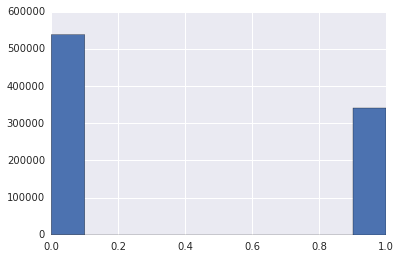

In [97]:
plt.hist(final_train_df['IsDuplicated'].values)

In [98]:
# creating final X (Input) and Y(output)
X = final_train_df[inputFeatures].values
Y = final_train_df[ouptutFeatures].values

In [99]:
#  scaling data
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

### 5. Dimensionality Reduction Using PCA

In [100]:
components = 60
pca = PCA(n_components=components)
#pca = RandomizedPCA(n_components=components, random_state=0)
#pca = IncrementalPCA(n_components=components, batch_size=10000)
X_pca = pca.fit_transform(X)

In [101]:
print pca.explained_variance_ratio_
print 'total variance explained : {0}'.format(np.sum(pca.explained_variance_ratio_))

[ 0.17  0.13  0.05  0.05  0.04  0.03  0.03  0.03  0.02  0.02  0.02  0.02
  0.02  0.02  0.02  0.02  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
total variance explained : 0.995003072506


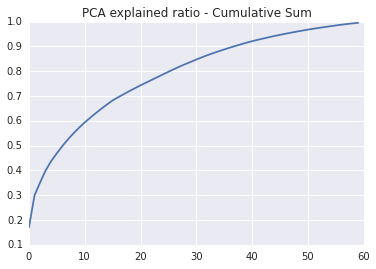

In [102]:
plt.plot(pca.explained_variance_ratio_.cumsum())
plt.title("PCA explained ratio - Cumulative Sum")

In [105]:
# using stratified shuffle split to create training and dev data
sss = StratifiedShuffleSplit(Y, train_size=0.5)
for train_index, dev_index in sss:
    train_data,dev_data=X_pca[train_index],X_pca[dev_index]
    train_labels,dev_labels=Y[train_index],Y[dev_index]

print train_data.shape, train_labels.shape
print dev_data.shape, dev_labels.shape
print len(np.unique(train_labels)), len(np.unique(dev_labels))

(438991, 60) (438991, 1)
(438988, 60) (438988, 1)
39 39


In [106]:
print train_data.shape, dev_data.shape

(438991, 60) (438988, 60)


## 6. Model Building and Training

### 6.1 Random Forest Models

In [107]:
# model 1 - Random Forest
rfc_1 = RandomForestClassifier(n_estimators=200,max_depth=20, random_state=6548, n_jobs=-1)
rfc_1.fit(train_data, train_labels.ravel())
print 'rfc-1  LogLoss {0}'.format(log_loss(dev_labels, rfc_1.predict_proba(dev_data)))

rfc-1  LogLoss 2.23713654534


####Error Analysis

In [61]:
# Classification report
print classification_report(dev_labels, rfc_1.predict(dev_data),target_names=unique_categories)

                             precision    recall  f1-score   support

                   WARRANTS       0.14      0.00      0.01       757
             OTHER OFFENSES       0.22      0.21      0.22     38436
              LARCENY/THEFT       0.00      0.00      0.00       203
              VEHICLE THEFT       0.00      0.00      0.00       145
                  VANDALISM       0.28      0.02      0.03     18377
               NON-CRIMINAL       0.09      0.01      0.02      2159
                    ROBBERY       0.00      0.00      0.00      1134
                    ASSAULT       0.37      0.45      0.40     26985
                WEAPON LAWS       0.02      0.00      0.00      2140
                   BURGLARY       0.00      0.00      0.00       583
             SUSPICIOUS OCC       0.00      0.00      0.00       128
                DRUNKENNESS       0.00      0.00      0.00       245
     FORGERY/COUNTERFEITING       0.29      0.01      0.02      5305
              DRUG/NARCOTIC      

In [75]:
#error analysis of Random Forest Classifier #1
wrong = []
errors = []
error_predictions = rfc_1.predict(dev_data)

def error_analysis():
    for num in range(error_predictions.shape[0]): #create list of wrong entries
        if dev_labels[num] != error_predictions[num]:
            wrong.append(num)
    for num in range(len(wrong)): #create list of most common errors
        errors.append(dev_labels[wrong[num]])

error_analysis()

In [76]:
#verify length of wrong and errors lists
print len(wrong)
print len(errors)
print len(error_predictions)

295197
295197
438988


In [77]:
#identify top 10 category errors
errors_count_list = []
def error_count():
    for num in range(39):
        errors_count_list.append(errors.count(num))
        print num, unique_categories[num], errors.count(num)

error_count()

0 WARRANTS 749
1 OTHER OFFENSES 29115
2 LARCENY/THEFT 203
3 VEHICLE THEFT 145
4 VANDALISM 16820
5 NON-CRIMINAL 2111
6 ROBBERY 1125
7 ASSAULT 14850
8 WEAPON LAWS 2132
9 BURGLARY 579
10 SUSPICIOUS OCC 128
11 DRUNKENNESS 240
12 FORGERY/COUNTERFEITING 5014
13 DRUG/NARCOTIC 8065
14 STOLEN PROPERTY 73
15 SECONDARY CODES 1158
16 TRESPASS 23635
17 MISSING PERSON 932
18 FRAUD 503
19 KIDNAPPING 7041
20 RUNAWAY 35286
21 DRIVING UNDER THE INFLUENCE 40755
22 SEX OFFENSES FORCIBLE 11
23 PROSTITUTION 1510
24 DISORDERLY CONDUCT 1556
25 ARSON 11251
26 FAMILY OFFENSES 763
27 LIQUOR LAWS 4957
28 BRIBERY 2034
29 EMBEZZLEMENT 74
30 SUICIDE 2262
31 LOITERING 248
32 SEX OFFENSES NON FORCIBLE 15422
33 EXTORTION 3
34 GAMBLING 3605
35 BAD CHECKS 21137
36 TREA 15977
37 RECOVERED VEHICLE 19695
38 PORNOGRAPHY/OBSCENE MAT 4033


In [78]:
#calculate error ratio for each category
total_count = []
error_ratios = []
def error_ratio():
    for num in range(39):
        total_count.append(dev_labels.tolist().count([num]))
    for num in range(39):
        ratio = float(errors_count_list[num])/float(total_count[num])
        error_ratios.append(ratio)
    for num in range(39):
        print num, unique_categories[num], errors_count_list[num], total_count[num], error_ratios[num]

error_ratio()

0 WARRANTS 749 757 0.989431968296
1 OTHER OFFENSES 29115 38436 0.757492975336
2 LARCENY/THEFT 203 203 1.0
3 VEHICLE THEFT 145 145 1.0
4 VANDALISM 16820 18377 0.915274527943
5 NON-CRIMINAL 2111 2159 0.977767484947
6 ROBBERY 1125 1134 0.992063492063
7 ASSAULT 14850 26985 0.550305725403
8 WEAPON LAWS 2132 2140 0.996261682243
9 BURGLARY 579 583 0.993138936535
10 SUSPICIOUS OCC 128 128 1.0
11 DRUNKENNESS 240 245 0.979591836735
12 FORGERY/COUNTERFEITING 5014 5305 0.945146088596
13 DRUG/NARCOTIC 8065 8339 0.967142343207
14 STOLEN PROPERTY 73 73 1.0
15 SECONDARY CODES 1158 1171 0.988898377455
16 TRESPASS 23635 87442 0.270293451659
17 MISSING PERSON 932 951 0.980021030494
18 FRAUD 503 613 0.820554649266
19 KIDNAPPING 7041 12995 0.541823778376
20 RUNAWAY 35286 46150 0.764593716143
21 DRIVING UNDER THE INFLUENCE 40755 63083 0.646053611908
22 SEX OFFENSES FORCIBLE 11 11 1.0
23 PROSTITUTION 1510 3742 0.403527525387
24 DISORDERLY CONDUCT 1556 1569 0.991714467814
25 ARSON 11251 11499 0.978432907209
2

In [79]:
overall_error_ratio = float(len(errors))/float(len(error_predictions))
print overall_error_ratio
#top 5 overall amount of errors with error ratios > overall error ratio of .67068: 20, 1, 35, 37, 4

0.672448905209


In [80]:
#check category names
top_errors = [20, 1, 35, 37, 4]
for num in top_errors:
    print unique_categories[num]

RUNAWAY
OTHER OFFENSES
BAD CHECKS
RECOVERED VEHICLE
VANDALISM


In [82]:
#examine top error categories
def error_category_analysis(category):
    category_wrong = []
    category_wrong_summary = []
    for num in range(dev_labels.shape[0]):
        if dev_labels[num] != error_predictions[num]:
            if dev_labels[num] == category:
                category_wrong.append(error_predictions[num])
    for num in range(39):
        category_wrong_summary.append([num, unique_categories[num], category_wrong.count([num])])
    print "Category:", category
    print "Category Label:", unique_categories[category]
    print category_wrong_summary

error_category_analysis(category = 20) #"Runaway" (20)
error_category_analysis(category = 1) #"Other Offenses" (1)
error_category_analysis(category = 35) #"Bad Checks" (35)
error_category_analysis(category = 37) #"Recovered Vehicle" (37)
error_category_analysis(category = 4) #"Vandalism" (4)


Category: 20
Category Label: RUNAWAY
[[0, 'WARRANTS', 9], [1, 'OTHER OFFENSES', 3108], [2, 'LARCENY/THEFT', 0], [3, 'VEHICLE THEFT', 0], [4, 'VANDALISM', 507], [5, 'NON-CRIMINAL', 17], [6, 'ROBBERY', 12], [7, 'ASSAULT', 1123], [8, 'WEAPON LAWS', 56], [9, 'BURGLARY', 2], [10, 'SUSPICIOUS OCC', 1], [11, 'DRUNKENNESS', 6], [12, 'FORGERY/COUNTERFEITING', 85], [13, 'DRUG/NARCOTIC', 227], [14, 'STOLEN PROPERTY', 0], [15, 'SECONDARY CODES', 4], [16, 'TRESPASS', 21255], [17, 'MISSING PERSON', 6], [18, 'FRAUD', 9], [19, 'KIDNAPPING', 609], [20, 'RUNAWAY', 0], [21, 'DRIVING UNDER THE INFLUENCE', 5741], [22, 'SEX OFFENSES FORCIBLE', 0], [23, 'PROSTITUTION', 82], [24, 'DISORDERLY CONDUCT', 6], [25, 'ARSON', 88], [26, 'FAMILY OFFENSES', 24], [27, 'LIQUOR LAWS', 85], [28, 'BRIBERY', 30], [29, 'EMBEZZLEMENT', 0], [30, 'SUICIDE', 7], [31, 'LOITERING', 32], [32, 'SEX OFFENSES NON FORCIBLE', 381], [33, 'EXTORTION', 0], [34, 'GAMBLING', 27], [35, 'BAD CHECKS', 473], [36, 'TREA', 873], [37, 'RECOVERED VEH

In [19]:
# model 2 - Random Forest
rfc_2 = RandomForestClassifier(n_estimators=200, max_depth=20, random_state=7837, n_jobs=-1)
rfc_2.fit(train_data, train_labels.ravel())
print 'rfc-2  LogLoss {0}'.format(log_loss(dev_labels, rfc_2.predict_proba(dev_data)))

rfc-2  LogLoss 2.2345568173


In [20]:
# model 3 - Random Forest
rfc_3 = RandomForestClassifier(n_estimators=200, max_depth=20, random_state=5382, n_jobs=-1)
rfc_3.fit(train_data, train_labels.ravel())
print 'rfc-3  LogLoss {0}'.format(log_loss(dev_labels, rfc_3.predict_proba(dev_data)))

rfc-3  LogLoss 2.23325756902


In [21]:
# model 4 - Random Forest
rfc_4 = RandomForestClassifier(n_estimators=200, max_depth=20, random_state=6432, n_jobs=-1)
rfc_4.fit(train_data, train_labels.ravel())
print 'rfc-4  LogLoss {0}'.format(log_loss(dev_labels, rfc_4.predict_proba(dev_data)))

rfc-4  LogLoss 2.23338251401


### Neural Network Models

In [70]:
from keras.layers.core import Dense, Activation
from keras.models import Sequential
from keras.layers.advanced_activations import PReLU
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential
from keras.utils import np_utils

In [71]:
def build_neural_network_model(num_features, num_classes, hiddenNeurons, dropOut):
    model = Sequential()   
    model.add(Dense(num_features, hiddenNeurons, init='glorot_uniform'))
    model.add(PReLU((hiddenNeurons,)))
    model.add(Dropout(dropOut))    
    model.add(Dense(hiddenNeurons, hiddenNeurons, init='glorot_uniform'))
    model.add(PReLU((hiddenNeurons,)))
    model.add(BatchNormalization((hiddenNeurons,)))
    model.add(Dropout(dropOut))
    model.add(Dense(hiddenNeurons, num_classes, init='glorot_uniform'))
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    
    return model

In [108]:
num_classes = len(category_encoder.classes_)
num_features = train_data.shape[1]
print 'No. of features : {0} No. of classes : {1}'.format(num_classes, num_features)

No. of features : 39 No. of classes : 60


In [73]:
# Neural Network Model
net_1 = build_neural_network_model(num_features, num_classes, 128, 0.5)
net_1.fit(train_data, np_utils.to_categorical(train_labels), nb_epoch=20,batch_size=64, validation_data=(dev_data,np_utils.to_categorical(dev_labels)))
print 'neural net  LogLoss {0}'.format(log_loss(dev_labels, net_1.predict_proba(dev_data)))

Train on 438991 samples, validate on 438988 samples
Epoch 0
438991/438991 [==============================] - 33s - loss: 2.3888 - val_loss: 2.2714
Epoch 1
438991/438991 [==============================] - 33s - loss: 2.3112 - val_loss: 2.2411
Epoch 2
438991/438991 [==============================] - 33s - loss: 2.2920 - val_loss: 2.2282
Epoch 3
438991/438991 [==============================] - 33s - loss: 2.2808 - val_loss: 2.2215
Epoch 4
438991/438991 [==============================] - 36s - loss: 2.2743 - val_loss: 2.2172
Epoch 5
438991/438991 [==============================] - 33s - loss: 2.2709 - val_loss: 2.2155
Epoch 6
438991/438991 [==============================] - 33s - loss: 2.2671 - val_loss: 2.2133
Epoch 7
438991/438991 [==============================] - 33s - loss: 2.2645 - val_loss: 2.2109
Epoch 8
438991/438991 [==============================] - 33s - loss: 2.2623 - val_loss: 2.2090
Epoch 9
438991/438991 [==============================] - 33s - loss: 2.2595 - val_loss: 2.207

In [26]:
# Neural Network Model
net_2 = build_neural_network_model(num_features, num_classes, 156, 0.4)
net_2.fit(train_data, np_utils.to_categorical(train_labels), nb_epoch=20,batch_size=64, validation_data=(dev_data,np_utils.to_categorical(dev_labels)))
print 'neural net  LogLoss {0}'.format(log_loss(dev_labels, net_2.predict_proba(dev_data)))

Train on 438991 samples, validate on 438988 samples
Epoch 0
438991/438991 [==============================] - 38s - loss: 2.3308 - val_loss: 2.2334
Epoch 1
438991/438991 [==============================] - 38s - loss: 2.2673 - val_loss: 2.2164
Epoch 2
438991/438991 [==============================] - 38s - loss: 2.2548 - val_loss: 2.2101
Epoch 3
438991/438991 [==============================] - 38s - loss: 2.2483 - val_loss: 2.2052
Epoch 4
438991/438991 [==============================] - 38s - loss: 2.2432 - val_loss: 2.2005
Epoch 5
438991/438991 [==============================] - 38s - loss: 2.2381 - val_loss: 2.1976
Epoch 6
438991/438991 [==============================] - 38s - loss: 2.2339 - val_loss: 2.1943
Epoch 7
438991/438991 [==============================] - 38s - loss: 2.2313 - val_loss: 2.1922
Epoch 8
438991/438991 [==============================] - 38s - loss: 2.2292 - val_loss: 2.1897
Epoch 9
438991/438991 [==============================] - 38s - loss: 2.2270 - val_loss: 2.188

## Gradient Boost Models

In [74]:
import sys
sys.path.append('/home/ubuntu/xgboost/python-package/')
import xgboost as xgb

In [75]:
xg_train = xgb.DMatrix( train_data, label=train_labels)
xg_test = xgb.DMatrix(dev_data, label=dev_labels)
# setup parameters for xgboost
param = {}
# use softmax multi-class classification
param['objective'] = 'multi:softprob'
# scale weight of positive examples
param['eta'] = 0.2
param['max_depth'] = 5
param['silent'] = 1
param['nthread'] = 12
param['num_class'] = len(category_encoder.classes_)
param['eval_metric'] = 'mlogloss'

watchlist = [ (xg_train,'train'), (xg_test, 'test') ]
num_round = 100
xgb_1 = xgb.train(param, xg_train, num_round, watchlist )
# get prediction
yprob = xgb_1.predict(xg_test).reshape( dev_data.shape[0],len(category_encoder.classes_))
print 'XGBM-1 LogLoss {0}'.format(log_loss(dev_labels, yprob))

[0]	train-mlogloss:3.196650	test-mlogloss:3.202579
[1]	train-mlogloss:3.005925	test-mlogloss:3.015783
[2]	train-mlogloss:2.872705	test-mlogloss:2.885857
[3]	train-mlogloss:2.771008	test-mlogloss:2.786862
[4]	train-mlogloss:2.690277	test-mlogloss:2.708697
[5]	train-mlogloss:2.624031	test-mlogloss:2.644905
[6]	train-mlogloss:2.569240	test-mlogloss:2.592546
[7]	train-mlogloss:2.522734	test-mlogloss:2.548299
[8]	train-mlogloss:2.483088	test-mlogloss:2.510986
[9]	train-mlogloss:2.448661	test-mlogloss:2.478757
[10]	train-mlogloss:2.418606	test-mlogloss:2.450896
[11]	train-mlogloss:2.392363	test-mlogloss:2.426732
[12]	train-mlogloss:2.369595	test-mlogloss:2.406175
[13]	train-mlogloss:2.348897	test-mlogloss:2.387543
[14]	train-mlogloss:2.330651	test-mlogloss:2.371342
[15]	train-mlogloss:2.313966	test-mlogloss:2.356815
[16]	train-mlogloss:2.299230	test-mlogloss:2.344210
[17]	train-mlogloss:2.285740	test-mlogloss:2.332907
[18]	train-mlogloss:2.273475	test-mlogloss:2.322883
[19]	train-mlogloss:2.

XGBM-1 LogLoss 2.21102282433


In [29]:
param['max_depth'] = 4
num_round = 150
xgb_2 = xgb.train(param, xg_train, num_round, watchlist )
# get prediction
yprob = xgb_2.predict(xg_test).reshape( dev_data.shape[0],len(category_encoder.classes_))
print 'XGBM-2 LogLoss {0}'.format(log_loss(dev_labels, yprob))

[0]	train-mlogloss:3.187345	test-mlogloss:3.190655
[1]	train-mlogloss:2.999607	test-mlogloss:3.004993
[2]	train-mlogloss:2.867185	test-mlogloss:2.874233
[3]	train-mlogloss:2.767232	test-mlogloss:2.775596
[4]	train-mlogloss:2.688137	test-mlogloss:2.697939
[5]	train-mlogloss:2.623496	test-mlogloss:2.634581
[6]	train-mlogloss:2.569621	test-mlogloss:2.581732
[7]	train-mlogloss:2.524605	test-mlogloss:2.537824
[8]	train-mlogloss:2.486232	test-mlogloss:2.500523
[9]	train-mlogloss:2.453451	test-mlogloss:2.468799
[10]	train-mlogloss:2.424895	test-mlogloss:2.441307
[11]	train-mlogloss:2.400316	test-mlogloss:2.417777
[12]	train-mlogloss:2.378697	test-mlogloss:2.397125
[13]	train-mlogloss:2.359648	test-mlogloss:2.379210
[14]	train-mlogloss:2.342689	test-mlogloss:2.363263
[15]	train-mlogloss:2.327728	test-mlogloss:2.349340
[16]	train-mlogloss:2.314406	test-mlogloss:2.336992
[17]	train-mlogloss:2.302325	test-mlogloss:2.325959
[18]	train-mlogloss:2.291606	test-mlogloss:2.316307
[19]	train-mlogloss:2.

XGBM-2 LogLoss 2.19728155867


### Model Ensemble

In [32]:
clfs = []
predictions = []
model_types = []
def ensemble_models(param_dev_data):   
    # model 1 - Random Forest  
    clfs.append(rfc_1)
    model_types.append('rf')
    # model 2 - Random Forest  
    clfs.append(rfc_2)
    model_types.append('rf')
    # model 3 - Random Forest  
    clfs.append(rfc_3)
    model_types.append('rf')
    # model 4 - Random Forest  
    clfs.append(rfc_4)
    model_types.append('rf')
    # model 5 - Neural Network  
    clfs.append(net_1)
    model_types.append('net')
    # model 6 - Neural Network  
    clfs.append(net_2)
    model_types.append('net')
    
    #model 7 - Gradient Boosting model
    clfs.append(xgb_1)
    model_types.append('xgbm')
    #model 8 - Gradient Boosting model
    clfs.append(xgb_2)
    model_types.append('xgbm')
    
    
    ### finding the optimum weights    
    for index in range(len(clfs)):
        clf = clfs[index]
        if model_types[index] == 'rf' or model_types[index] == 'net':
            predictions.append(clf.predict_proba(param_dev_data))
        
        if model_types[index] == 'xgbm':
            predictions.append(clf.predict(xgb.DMatrix(param_dev_data)).reshape(param_dev_data.shape[0],len(category_encoder.classes_)))
    
    #the algorithms need a starting value, right not we chose 0.5 for all weights
    #its better to choose many random starting points and run minimize a few times
    starting_values = [0.5]*len(predictions)

  
    #constraint
    cons = ({'type':'eq','fun':lambda w: 1-sum(w)})
    #our weights are bound between 0 and 1
    bounds = [(0,1)]*len(predictions)

    res = minimize(log_loss_func, starting_values, method='SLSQP', bounds=bounds, constraints=cons)

    print 'Ensamble Score: {0}'.format(res['fun'])
    print 'Best Weights: {0}'.format(res['x'])
    return clfs, res['x']
    
def log_loss_func(weights):    
    final_prediction = 0
    for weight, prediction in zip(weights, predictions):
            final_prediction += weight*prediction
    return log_loss(dev_labels, final_prediction)




In [33]:
models, weights = ensemble_models(dev_data)

438988/438988 [==============================] - 7s     
Ensamble Score: 2.15656439065
Best Weights: [  6.92724963e-02   7.53927681e-02   4.36805970e-02   8.26791540e-02
  -9.91706175e-17   6.01710196e-01   8.25305303e-02   4.47342580e-02]


### Evaluation

In [34]:
# preparate test data
test_data = final_test_df[inputFeatures].values
test_data = scaler.transform(test_data)
print test_data.shape
test_data_pca = pca.transform(test_data)
print test_data.shape, test_data_pca.shape

(884262, 109)
(884262, 109) (884262, 60)


In [35]:
# compute test output
final_prob = np.zeros((test_data_pca.shape[0], len(category_encoder.classes_)))
for index in range(len(models)):
    model = models[index]
    if model_types[index] == 'rf' or model_types[index] == 'net':
        probs = model.predict_proba(test_data_pca)       
        
    if model_types[index] == 'xgbm':        
        probs = model.predict(xgb.DMatrix(test_data_pca)).reshape(test_data_pca.shape[0],len(category_encoder.classes_))
    probs = probs * weights[index]
    final_prob = final_prob + probs
print final_prob.shape

884262/884262 [==============================] - 14s    
(884262, 39)


In [36]:
# round up the results
submit_output = np.around(final_prob, decimals=10)
print submit_output.shape

(884262, 39)


### Submission Preperation

In [37]:
result = np.c_[final_test_df['Id'].astype(int), submit_output.astype(float)]
print result.shape
outputColumns =  ['Id'] + list( category_encoder.classes_)
df_result = pd.DataFrame(result, columns=outputColumns)
df_result['Id'] = df_result['Id'].astype(int)
print df_result.info()

(884262, 40)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 884262 entries, 0 to 884261
Data columns (total 40 columns):
Id                             884262 non-null int64
ARSON                          884262 non-null float64
ASSAULT                        884262 non-null float64
BAD CHECKS                     884262 non-null float64
BRIBERY                        884262 non-null float64
BURGLARY                       884262 non-null float64
DISORDERLY CONDUCT             884262 non-null float64
DRIVING UNDER THE INFLUENCE    884262 non-null float64
DRUG/NARCOTIC                  884262 non-null float64
DRUNKENNESS                    884262 non-null float64
EMBEZZLEMENT                   884262 non-null float64
EXTORTION                      884262 non-null float64
FAMILY OFFENSES                884262 non-null float64
FORGERY/COUNTERFEITING         884262 non-null float64
FRAUD                          884262 non-null float64
GAMBLING                       884262 non-null float6

In [38]:
df_result.to_csv('14-SFCrimeMIDSChallengerTeam.csv', index=False,header=True)